In [1]:
import os
import numpy as np
import pandas as pd

import json
import pickle

# import cfdna_covid19

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
font_size = 10
rc={'font.size': font_size, 'axes.labelsize': font_size, 'figure.dpi':400, 'axes.linewidth':1,
    'axes.titlesize': font_size, 'xtick.labelsize': font_size, 'ytick.labelsize': font_size} # 'figure.figsize':(11.7/1.5,8.27/1.5)

flatui_3risk = ['#e41a1c','#4daf4a','#ff7f00']
flatui_2cls = ['#377eb8', '#984ea3']

flatui = ['#ff7f00','#4daf4a','#984ea3','#377eb8', '#e41a1c']

sns.set(style='ticks',rc=rc) #talk, ticks, paper
sns.set_context("paper")
# sns.palplot(sns.color_palette(flatui))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.unicode_minus']=False # negative minus sign

centimeter = 1/2.54  # centimeter in inches


In [4]:
import sklearn
print('sklearn:'+sklearn.__version__)

from sklearn import metrics
from scipy import stats

sklearn:0.23.2


In [5]:
# load tss-gene name
tss_gene_ls_fname = r'~/20211104_model_feature/tss_177_trans_and_169gene.list'
tss_gene_df = pd.read_csv(tss_gene_ls_fname,sep='\t',names=['tss','gene','trans'], header=None)


In [6]:
tss_gene_df.head(10)

tss         gene                                trans
0  gene_1_33376      TNFAIP3  NM_001270508,NM_001270507,NM_006290
1  gene_1_33425         PEX3                            NM_003630
2  gene_0_33456         GRM1            NM_001278067,NM_001278066
3  gene_0_33543       MTRF1L                         NM_001301872
4  gene_0_33574       ARID1B                         NM_001363725
5  gene_0_33589       DYNLT1  NM_001291603,NM_001291602,NM_006519
6  gene_0_33593      EZR-AS1                            NR_102425
7  gene_0_33599      C6orf99                            NR_160979
8  gene_1_33678  RPS6KA2-AS1                            NR_046644
9  gene_0_33702    KIF25-AS1                            NR_103750

In [7]:
model_re_root_dir = r'~/model'

raw_data_dir = r'~/data'

tss_cover_fname = r'~/20211104_model_feature/all.coverage.17tss'

reads_cnt_fname='BY-399.bamstat.info.list'

feat_types = 'lab, fragl, tss, motif, m2model'

map_name= {'lab': 'LABModel', 'fragl': 'FRAGLModel', 'tss': 'TSSModel', 'motif': 'MOTIFModel', 'm2model': 'M2Model'}




In [8]:
max_feat_idx_ap = {'lab': 14, 'fragl': 6, 'tss': 31, 'motif': 28, 'm2model': 20}
def load_feat_importance_shap(i_feat_type, return_all=False):
    feat_imp_df = pd.read_csv(os.path.join(model_re_root_dir,i_feat_type+'/33_fl_feature_importance_shap.csv'), sep='\t')
    if return_all:
        return feat_imp_df
    else:
        return feat_imp_df.iloc[:max_feat_idx_ap[i_feat_type]+1,:]

def load_all_feats_name():
    lab_feat_imp_df = pd.read_csv(os.path.join(model_re_root_dir,'lab/33_fl_feature_importance_shap.csv'), sep='\t')
    fragl_feat_imp_df = pd.read_csv(os.path.join(model_re_root_dir,'fragl/33_fl_feature_importance_shap.csv'), sep='\t')
    tss_feat_imp_df = pd.read_csv(os.path.join(model_re_root_dir,'tss/33_fl_feature_importance_shap.csv'), sep='\t')
    motif_feat_imp_df = pd.read_csv(os.path.join(model_re_root_dir,'motif/33_fl_feature_importance_shap.csv'), sep='\t')
    
    feat_names = {}
    feat_names['lab']=lab_feat_imp_df['feat_name'].values
    feat_names['fragl']=fragl_feat_imp_df['feat_name'].values
    feat_names['tss']=tss_feat_imp_df['feat_name'].values
    feat_names['motif']=motif_feat_imp_df['feat_name'].values
    
    return feat_names
    

In [9]:
# get patient info
pat_info = pd.concat([pd.read_csv(os.path.join(raw_data_dir, '399_train_2class_01.csv')),
                     pd.read_csv(os.path.join(raw_data_dir, '399_test_2class_01.csv'))])


In [10]:
# get features from m2model
m2model_feats = load_feat_importance_shap('m2model')['feat_name'].values
featnames = load_all_feats_name()
f_type=[]
for f in m2model_feats:
    for iiidx, t in enumerate('lab,fragl,tss,motif'.split(',')):
        if f in featnames[t]:
            f_type.append(t)
            break

f_type = np.array(f_type)

/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  import sys


In [11]:
reads_avg_depth_df = pd.read_csv(os.path.join(raw_data_dir,reads_cnt_fname),sep='\t')[['Sample','Average sequencing depth        ']]
reads_avg_depth_df.rename(columns={'Sample':'ind','Average sequencing depth        ':'avg_depth'}, inplace=True)

In [12]:
reads_avg_depth_df.head()

ind  avg_depth
0  DP9095635_D0313-2      11.26
1  DP9241254_D0307-1       7.61
2  DP9241263_D0309-1      14.42
3  DP9241266_D0306-1      17.96
4  DP9241267_D0306-1       7.55

# TSS coverage

In [13]:
tss_cov_dat = pd.read_csv(tss_cover_fname, sep='\t')
tss_names = m2model_feats[f_type=='tss']

In [ ]:
tss_cov_dat.head()

In [15]:
tss_names

array(['gene_0_36079', 'gene_1_38365', 'gene_1_34557', 'gene_1_35660',
       'gene_0_34371', 'gene_1_37604', 'gene_0_37969', 'gene_0_33748',
       'gene_1_33376', 'gene_0_38356', 'gene_1_36592', 'gene_0_35754',
       'gene_0_37102', 'gene_0_34227', 'gene_0_35092', 'gene_1_33775',
       'gene_1_34781'], dtype=object)

In [16]:
tss_gene_df[tss_gene_df['tss'].isin(tss_names)]

tss          gene  \
0    gene_1_33376       TNFAIP3   
11   gene_0_33748        FAM20C   
12   gene_1_33775         COX19   
24   gene_0_34227          YAE1   
29   gene_0_34371      EGFR-AS1   
35   gene_1_34557          NCF1   
41   gene_1_34781          ASB4   
49   gene_0_35092        LSMEM1   
62   gene_1_35660         CNPY1   
64   gene_0_35754  DEFA1B,DEFA1   
74   gene_0_36079       PPP2R2A   
84   gene_1_36592          RBIS   
105  gene_0_37102         GSDMD   
131  gene_1_37604       MIR4475   
151  gene_0_37969        ZNF484   
167  gene_0_38356         OR1L3   
168  gene_1_38365        ZBTB26   

                                                 trans  
0                  NM_001270508,NM_001270507,NM_006290  
11                                           NM_020223  
12                                        NM_001031617  
24                              NM_001282446,NM_020192  
29                                           NR_047551  
35                                           NM_000265  
41                                           NM_145872  
49                                        NM_001134468  
62   NM_001369818,NM_001369816,NM_001369815,NR_1631...  
64                 NM_001302265,NM_004084,NM_001042500  
74                                        NM_001177591  
84   NM_001099672,NM_001099670,NM_001293320,NM_0010...  
105                                          NM_024736  
131                                          NR_039686  
151                                       NM_001354536  
167                                       NM_001005234  
168                                       NM_001304364

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


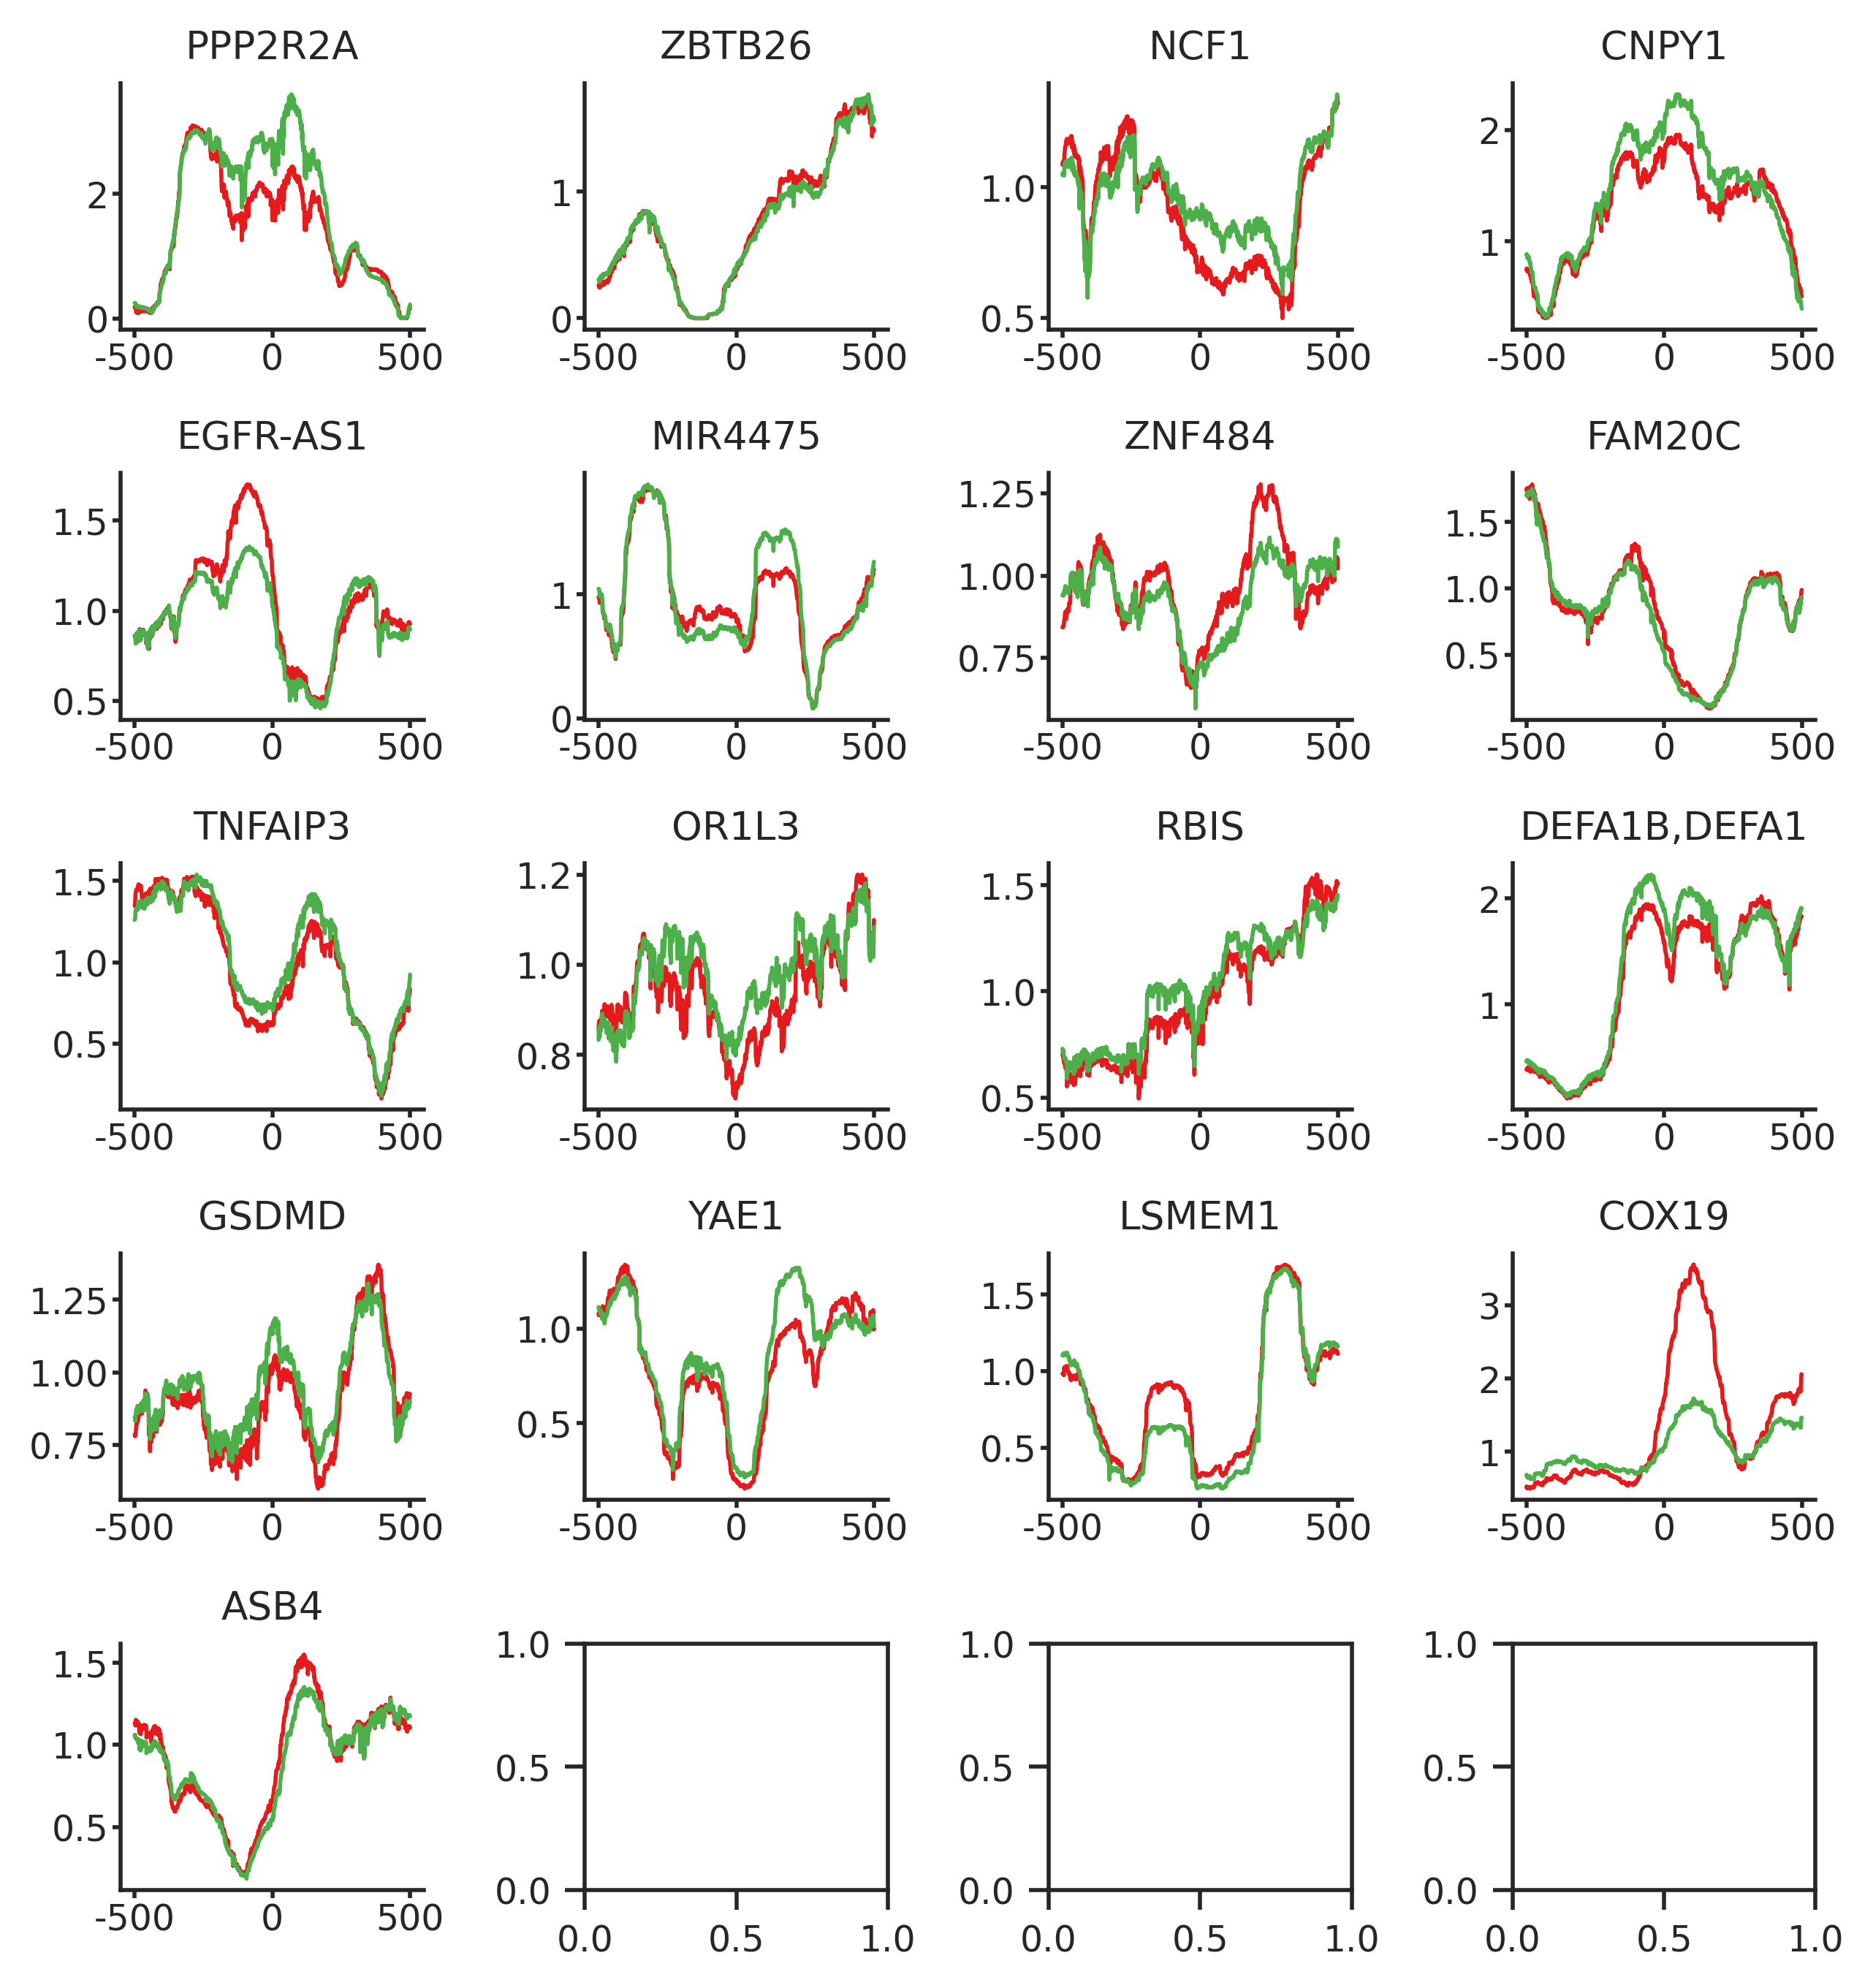

In [17]:
n_feat_tss = len(tss_names)
plot_col_n = 4
    
fig, axs = plt.subplots(int(np.ceil(n_feat_tss/plot_col_n)),plot_col_n,
                        figsize=(16.5*centimeter,3.5*int(np.ceil(n_feat_tss/plot_col_n))*centimeter))
axs = axs.ravel()

for iddd, i_tss in enumerate(tss_names):
    
    gene_name = tss_gene_df.loc[tss_gene_df['tss']==i_tss, 'gene'].values[0]
    
    p_tss_cov = tss_cov_dat[tss_cov_dat['gene']==i_tss].copy()
    p_tss_cov.sort_values(by='site', inplace=True)
    p_tss_cov = p_tss_cov.iloc[:,4:].T.copy()
    p_tss_cov['ind']=p_tss_cov.index
    p_tss_cov.reset_index(drop=True, inplace=True)
    p_tss_cov_info = p_tss_cov.merge(pat_info, on='ind')
    p_tss_cov_info_avg_depth = p_tss_cov_info.merge(reads_avg_depth_df, on='ind')
    p_tss_cov_info_avg_depth.iloc[:,:-3] = p_tss_cov_info_avg_depth.iloc[:,:-3].div(p_tss_cov_info_avg_depth['avg_depth'], axis=0)
    
    criticals = []
    non_criticals =[]

    for index, row in p_tss_cov_info_avg_depth.iterrows():
        i_dat1 = row[:-3].values
        # divided by flank depth
        over_avg = i_dat1[list(np.arange(0,250))+list(np.arange(750,1000))].mean()
        if over_avg == 0:
            over_avg = i_dat1.mean()
        i_dat =i_dat1/over_avg
        
        if row['new_triage'] == 1:
            color = "#e41a1c"
            criticals.append(i_dat)
            alpha=0.04
        else:
            color = "#4daf4a"
            non_criticals.append(i_dat)
            alpha=0.02
        # axs[iddd].plot(np.arange(-500,501), i_dat, c=color, alpha=alpha, lw=0.3)
    
    axs[iddd].plot(np.arange(-500,501),np.mean(criticals,axis=0), c="#e41a1c",lw=1,label='Noncritical')
    axs[iddd].plot(np.arange(-500,501),np.mean(non_criticals,axis=0), c="#4daf4a",lw=1,label='Critical')
    axs[iddd].set_xticks([-500,0,500])
    axs[iddd].tick_params(direction='out', length=2,pad=1)
    axs[iddd].spines['top'].set_visible(False)
    axs[iddd].spines['right'].set_visible(False)
    axs[iddd].set_title(gene_name)
    
plt.tight_layout()
plt.savefig("results_plt/raw_data_tss_cov_m2model.pdf", dpi=400, bbox_inches='tight', format='pdf')
    

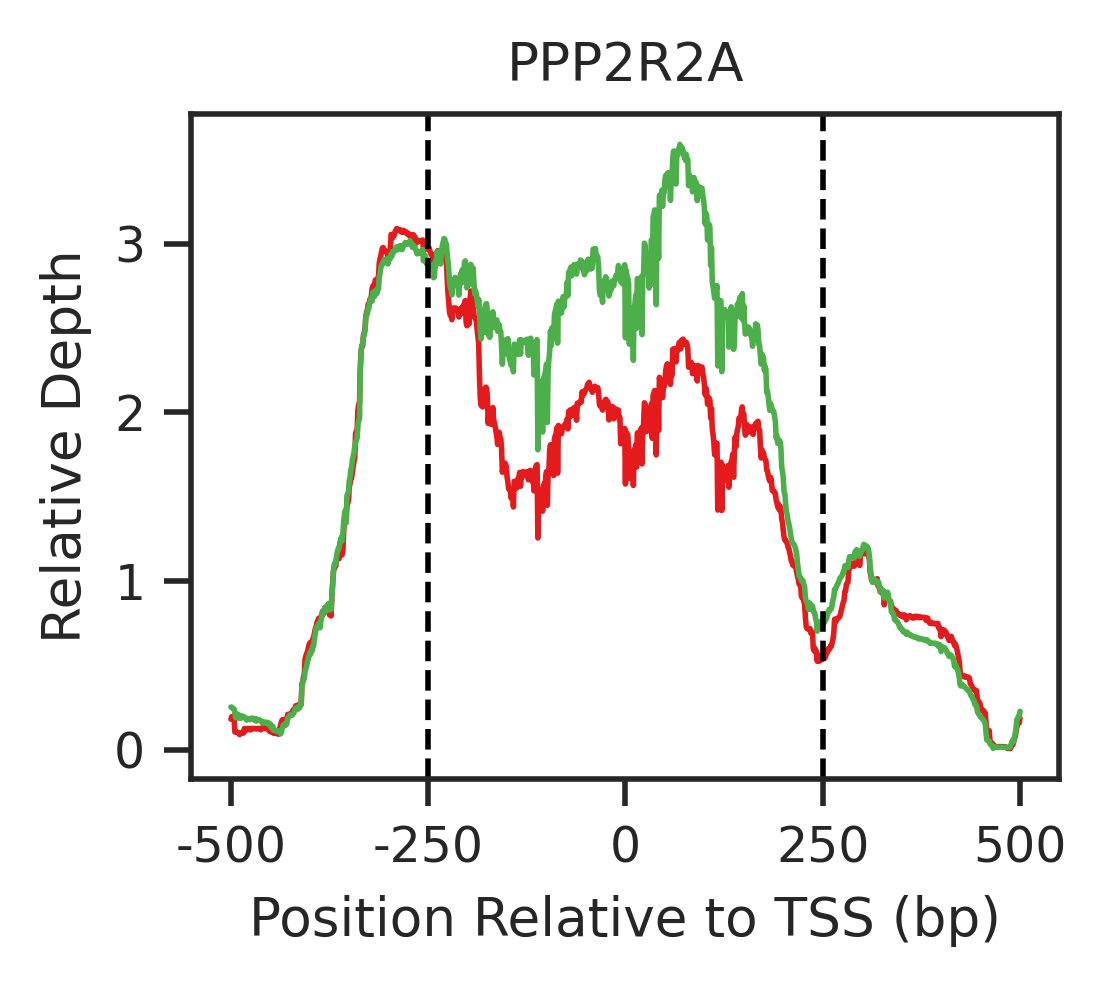

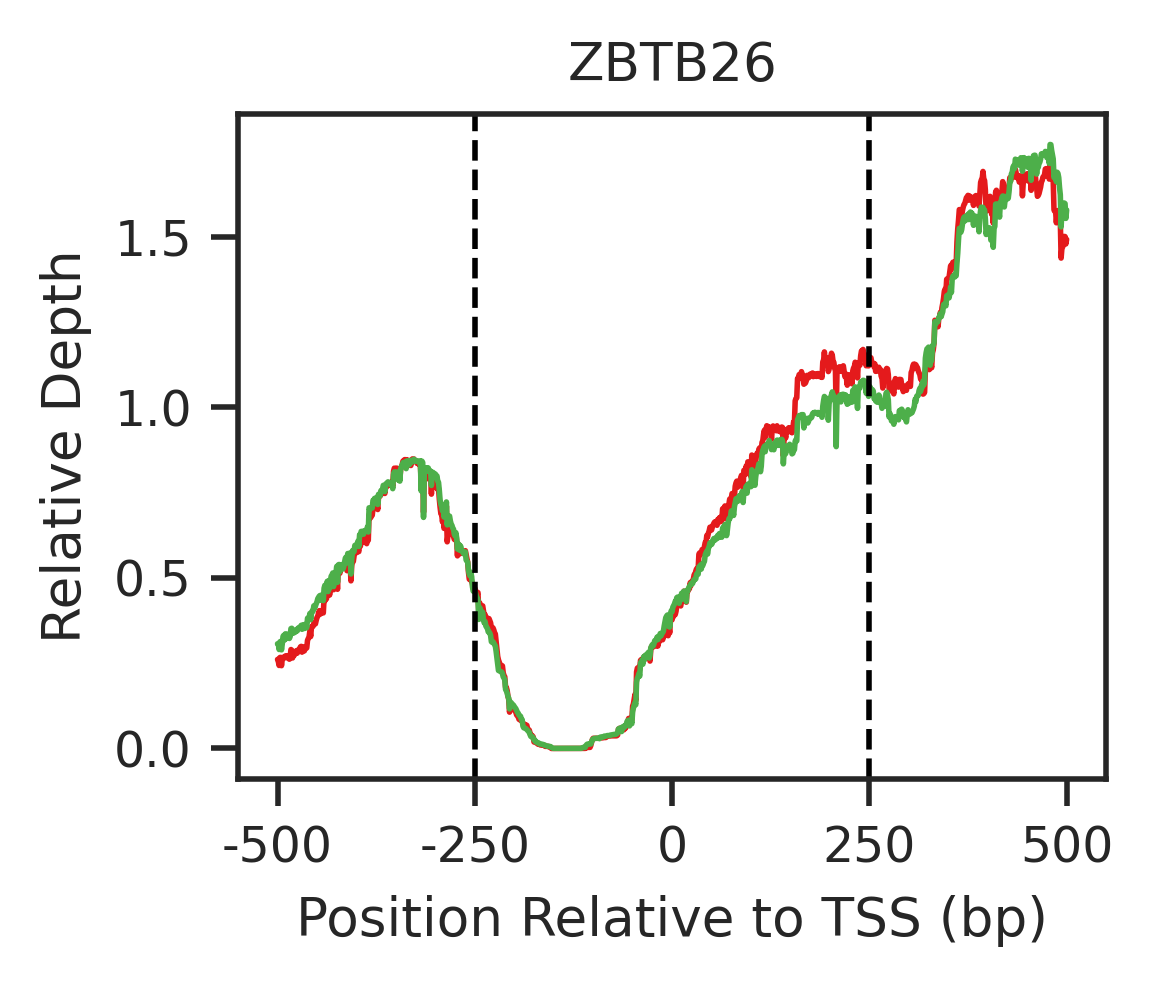

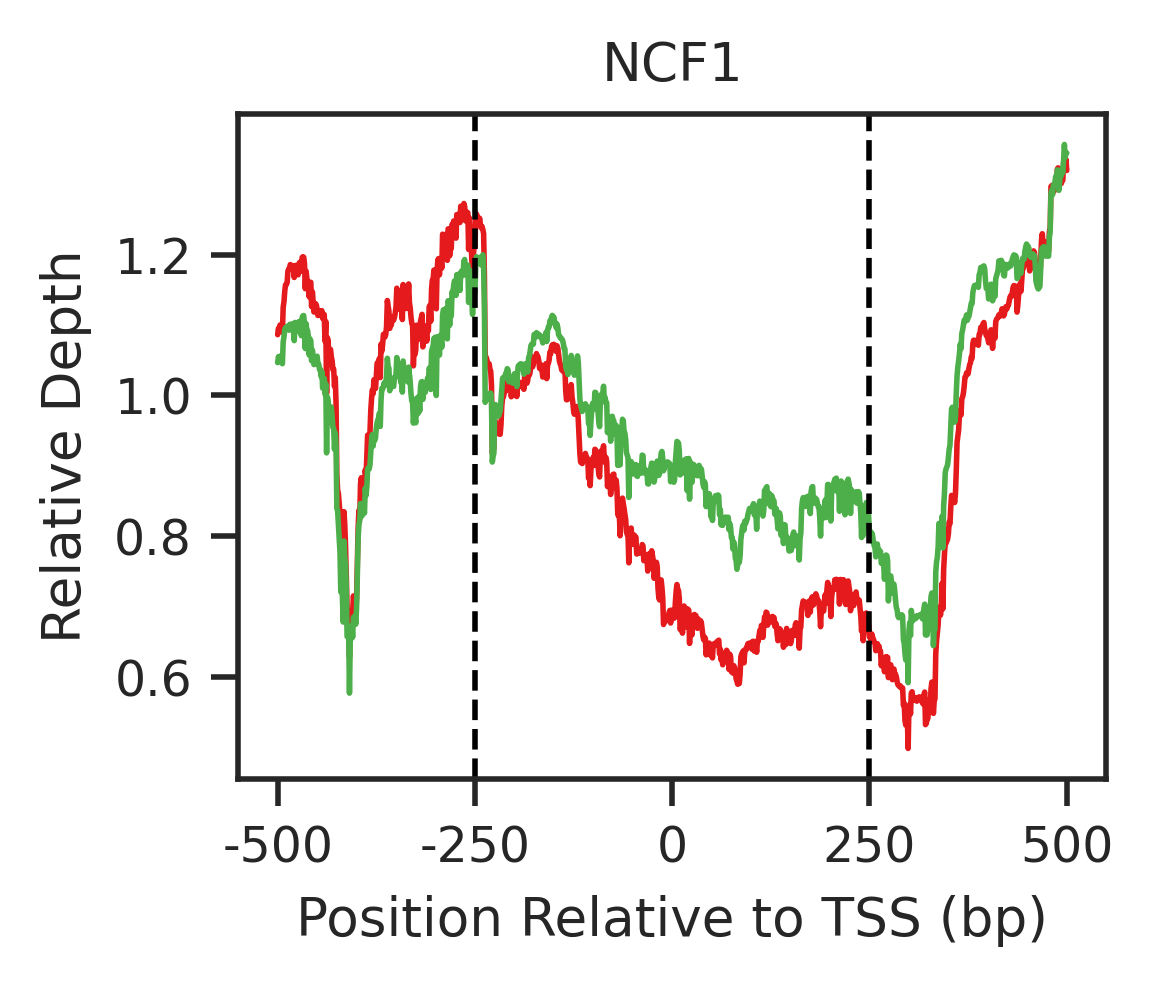

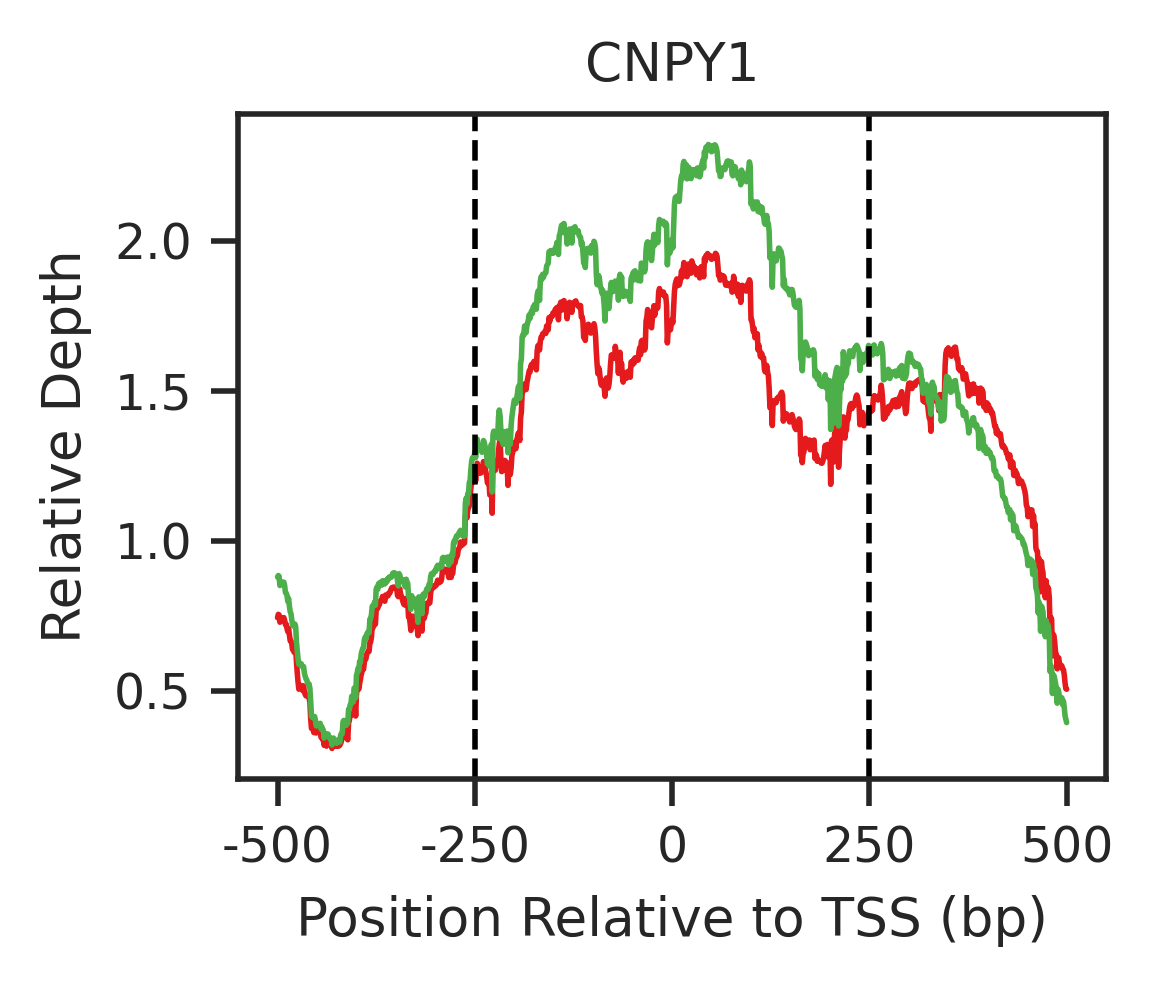

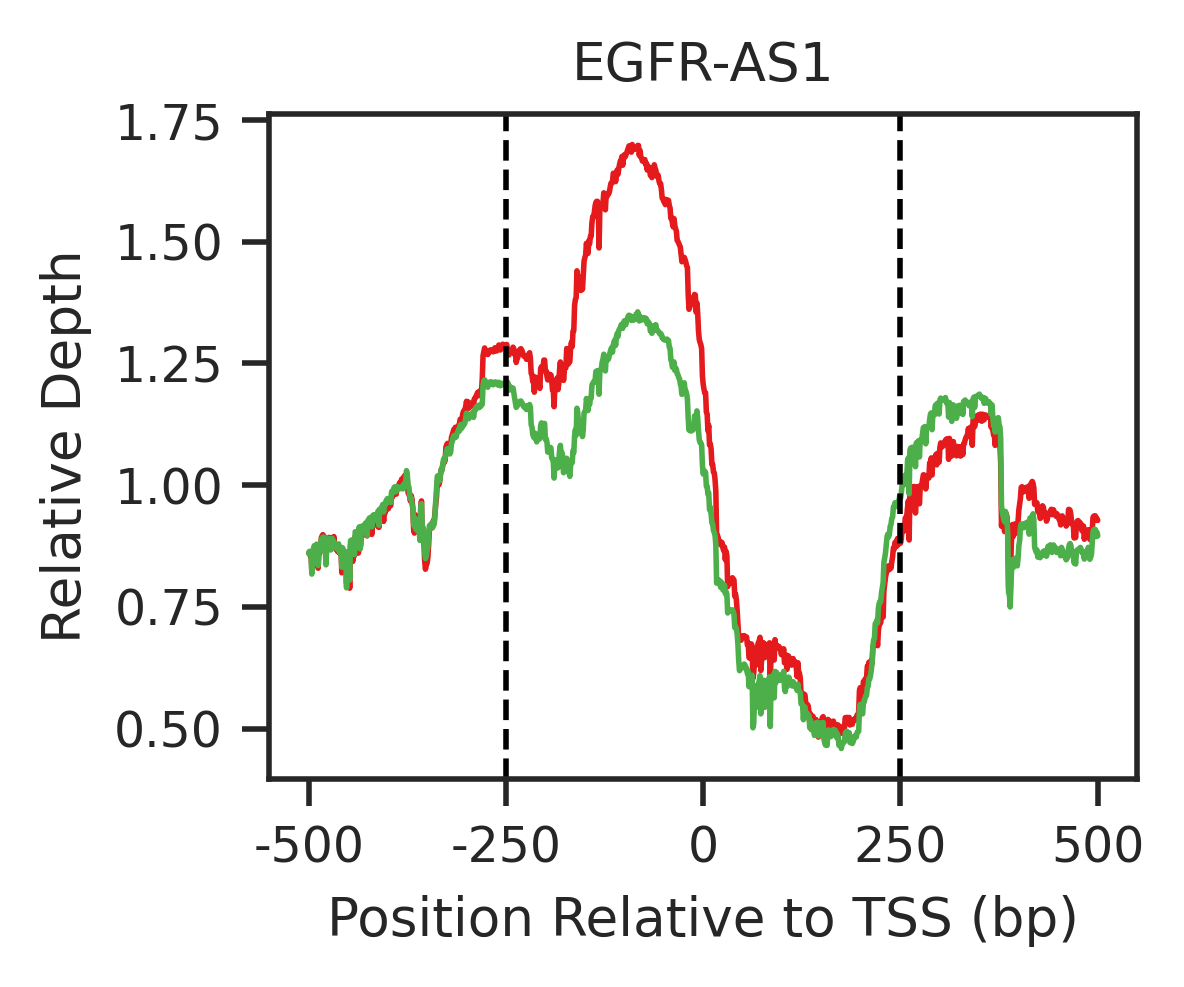

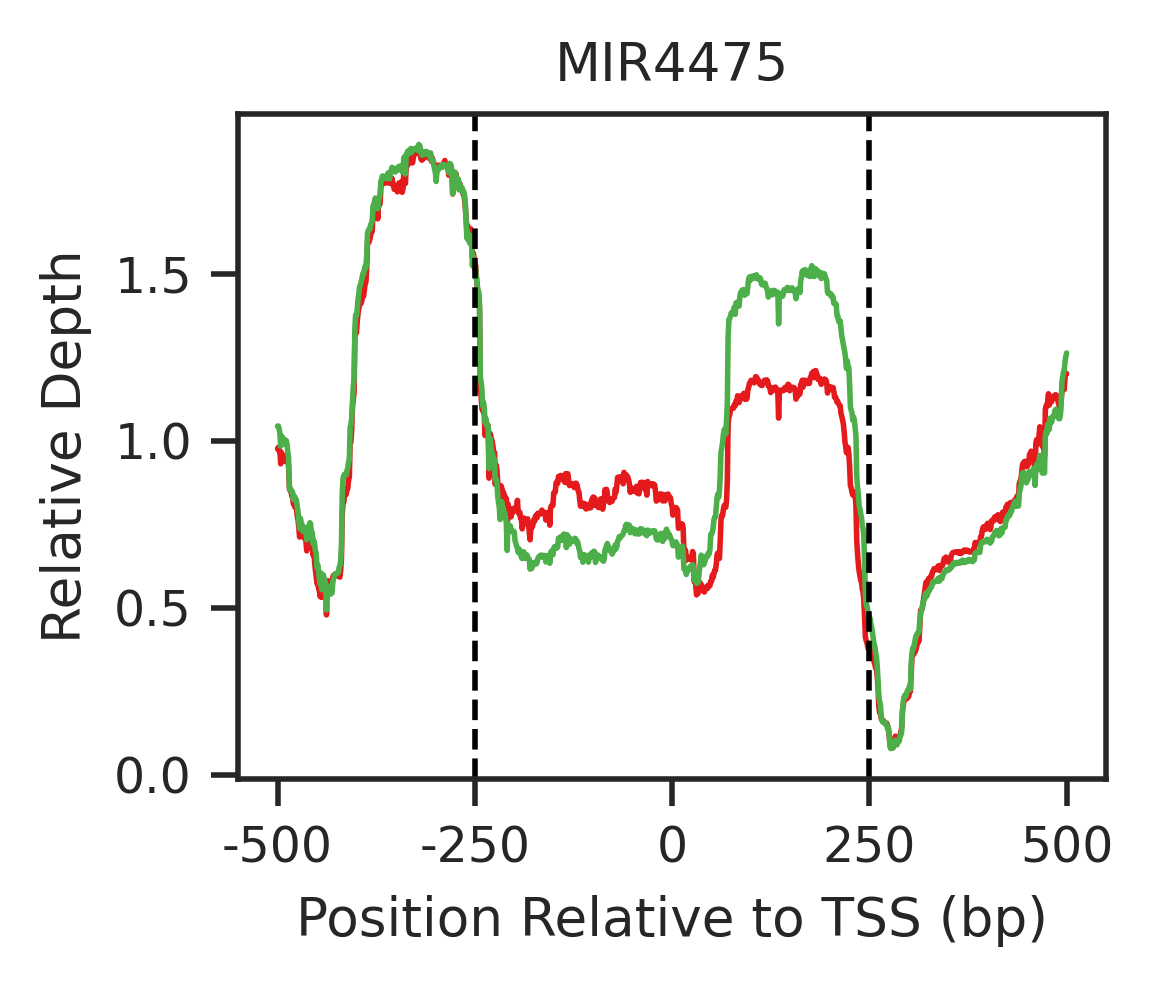

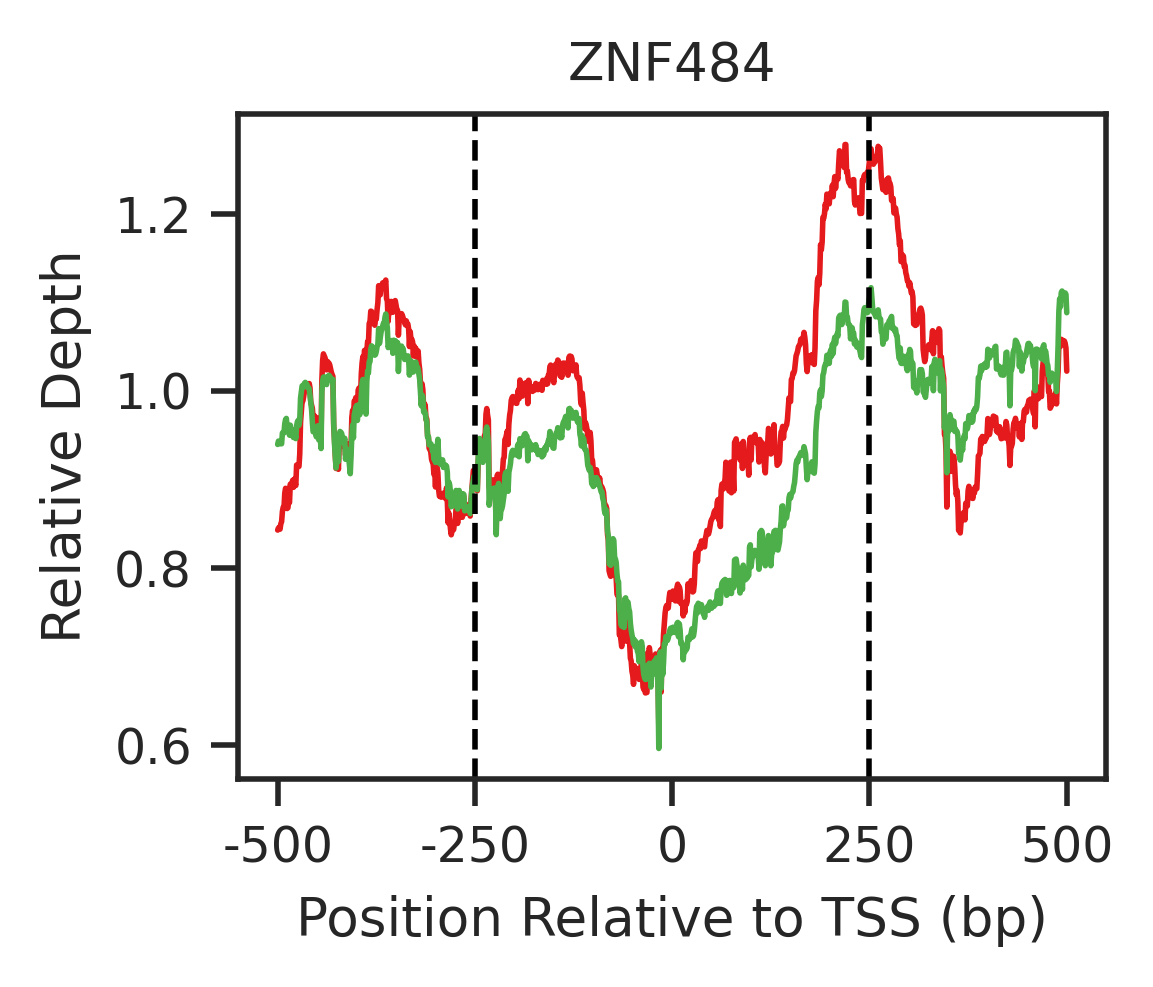

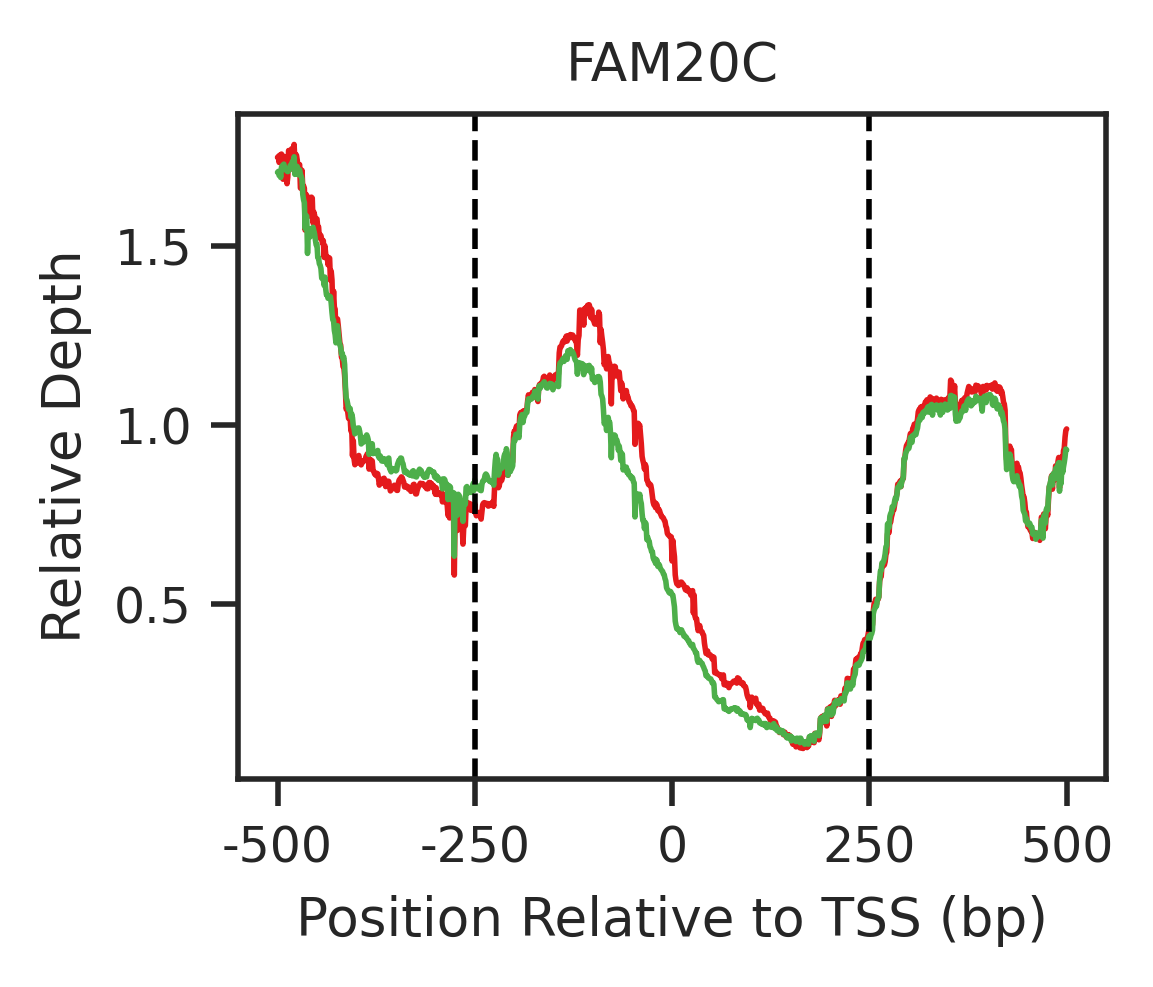

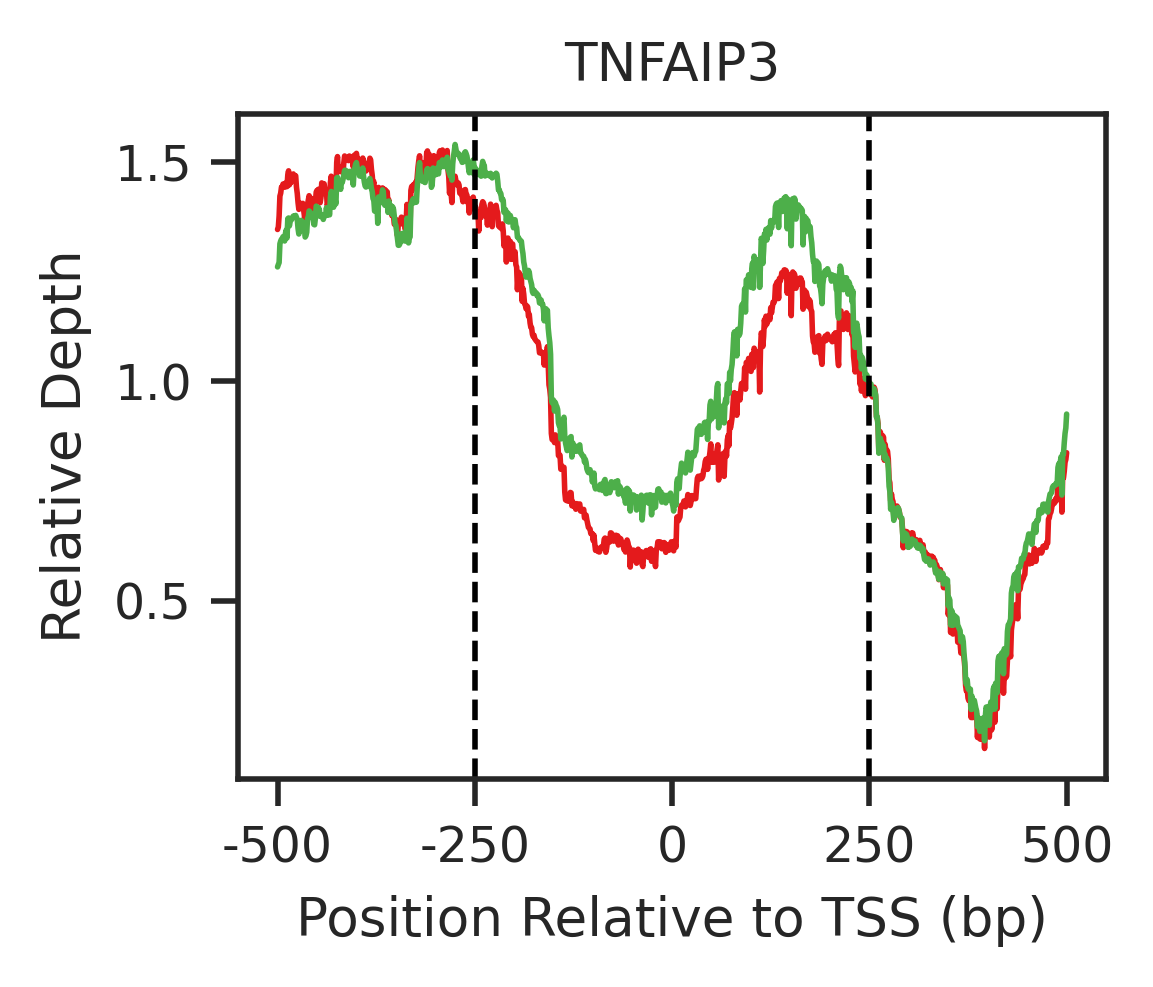

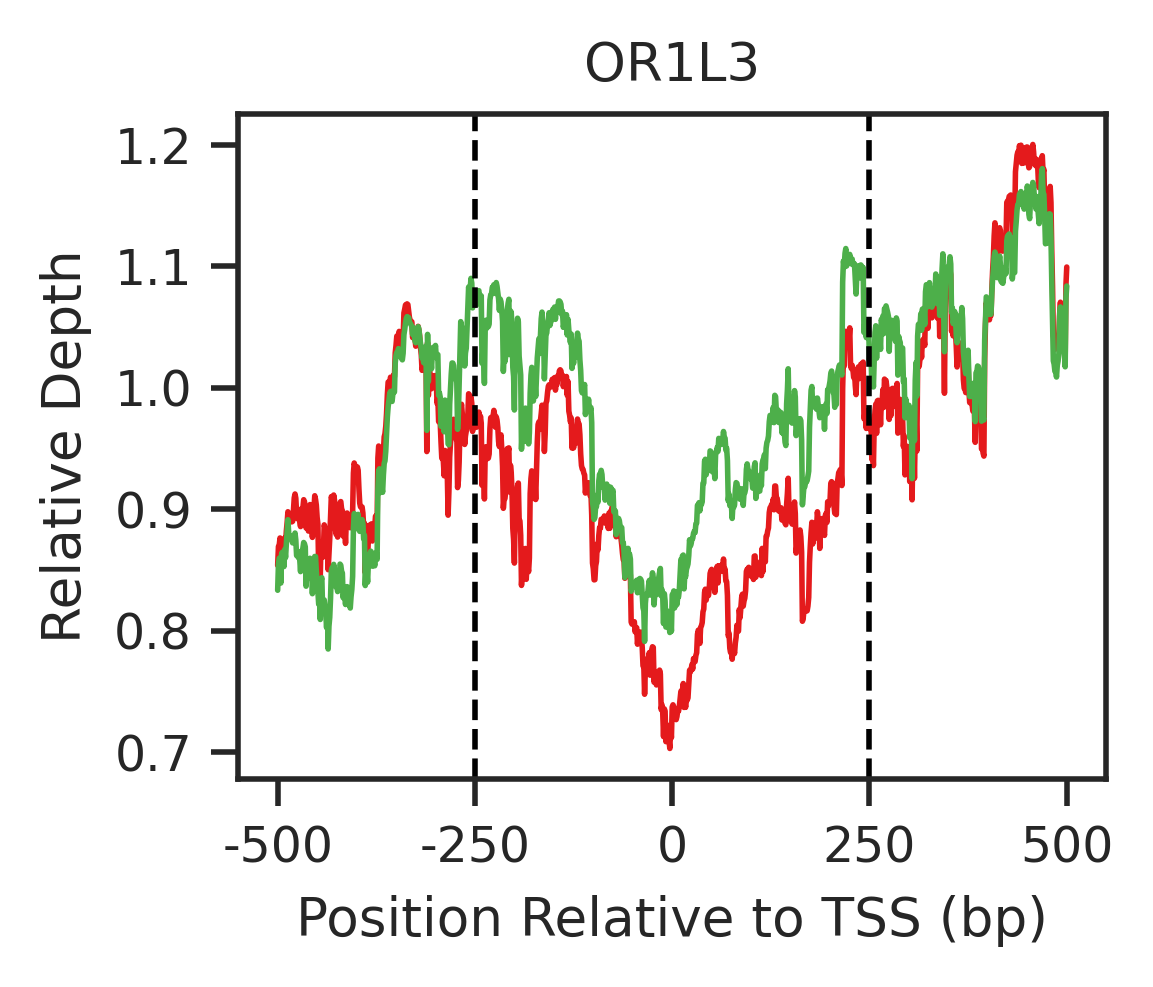

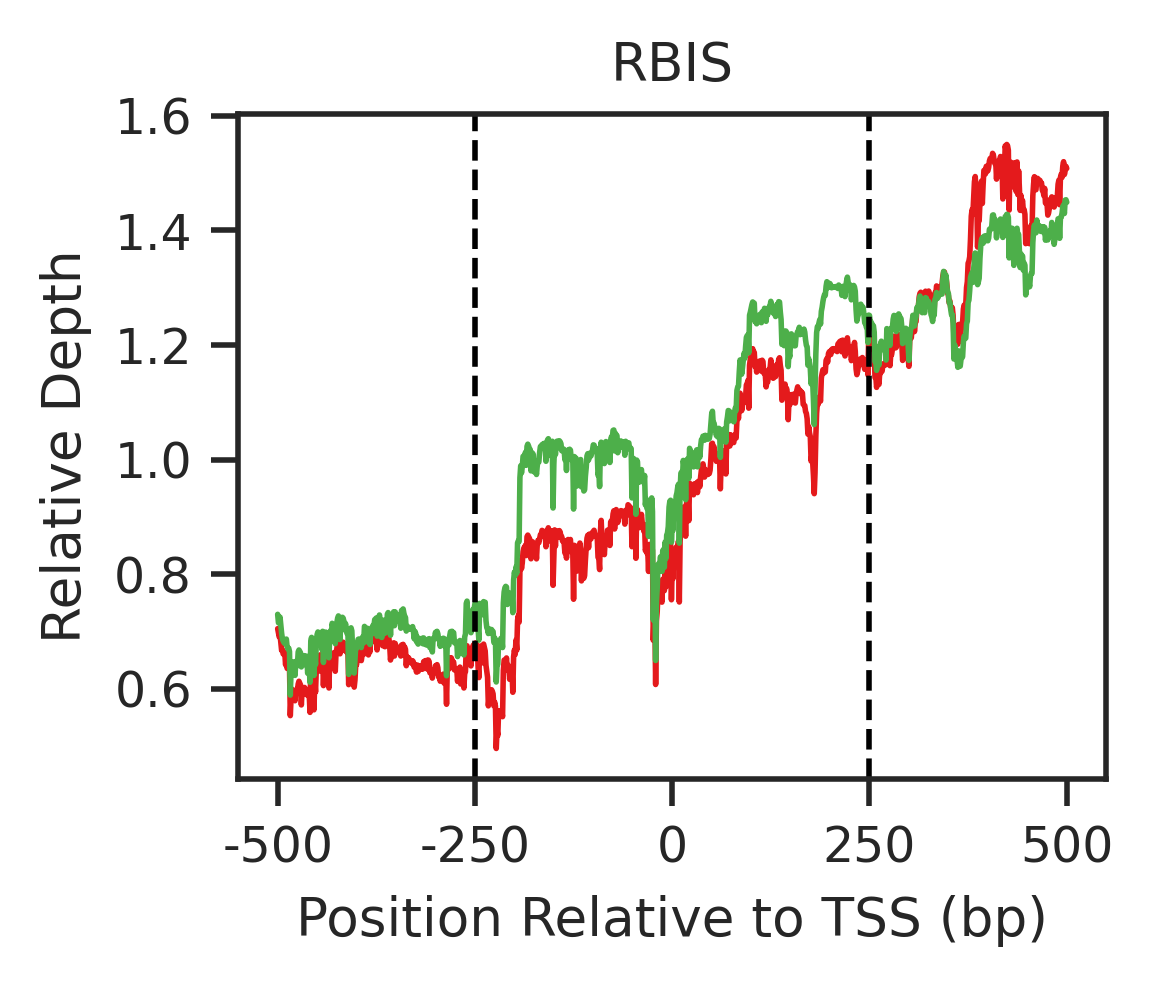

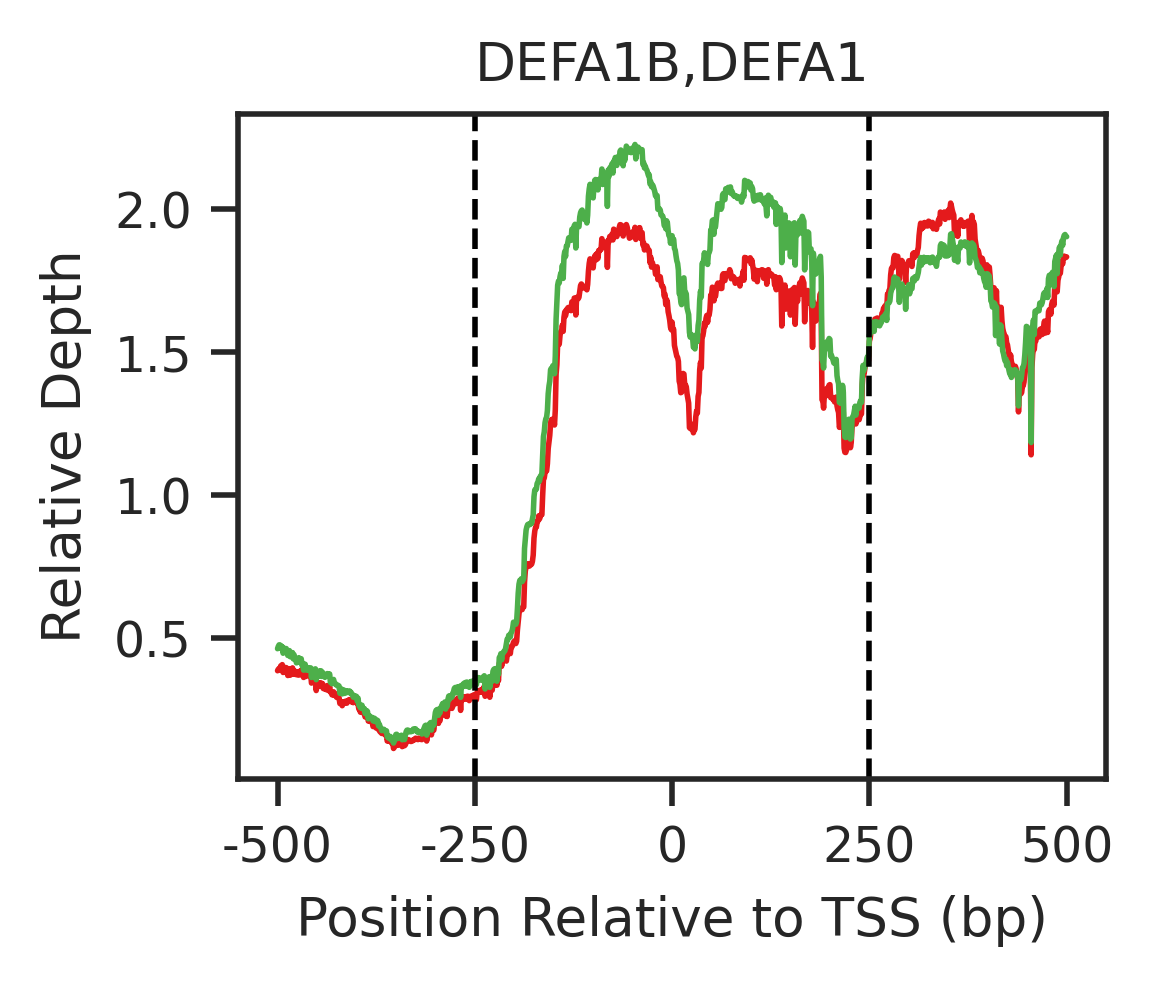

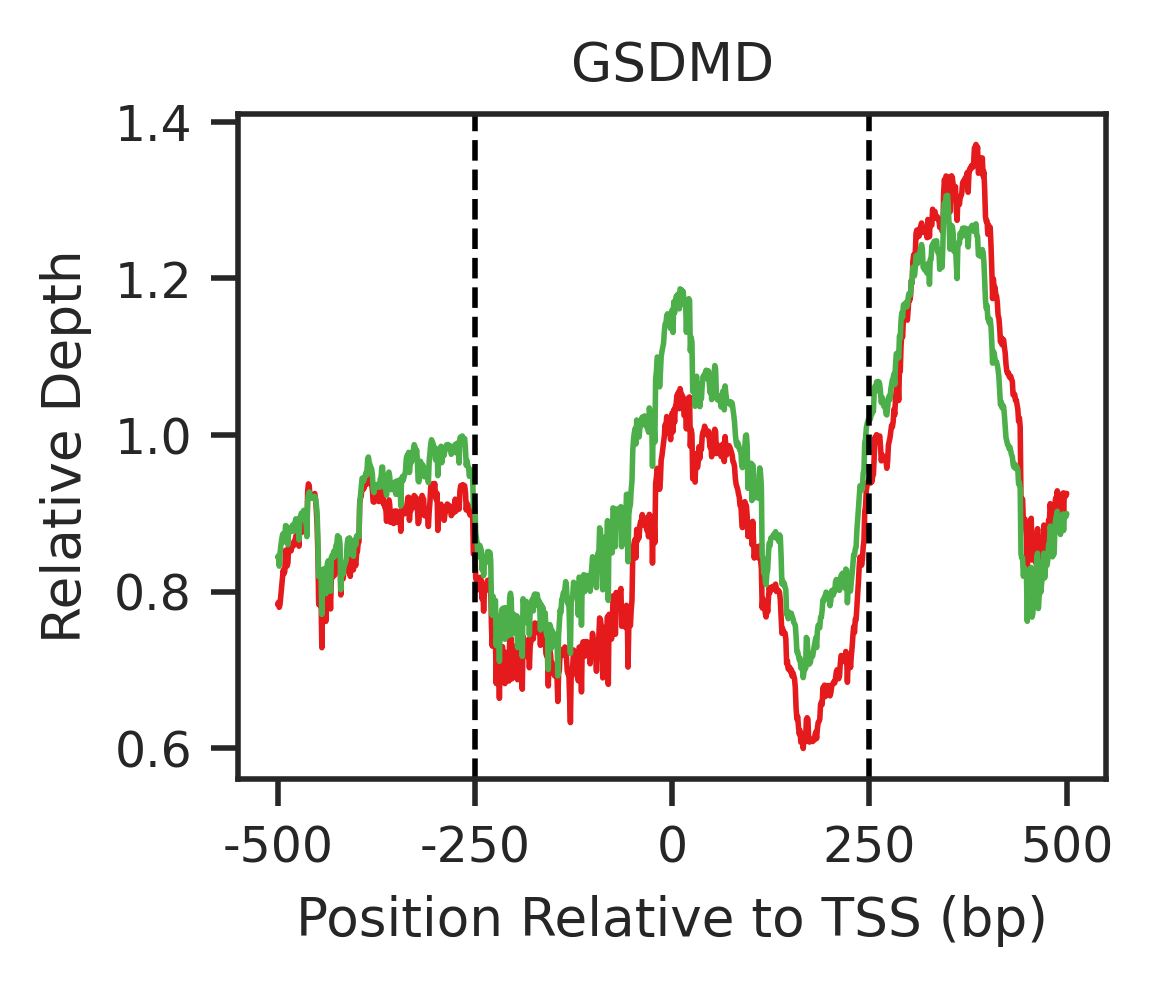

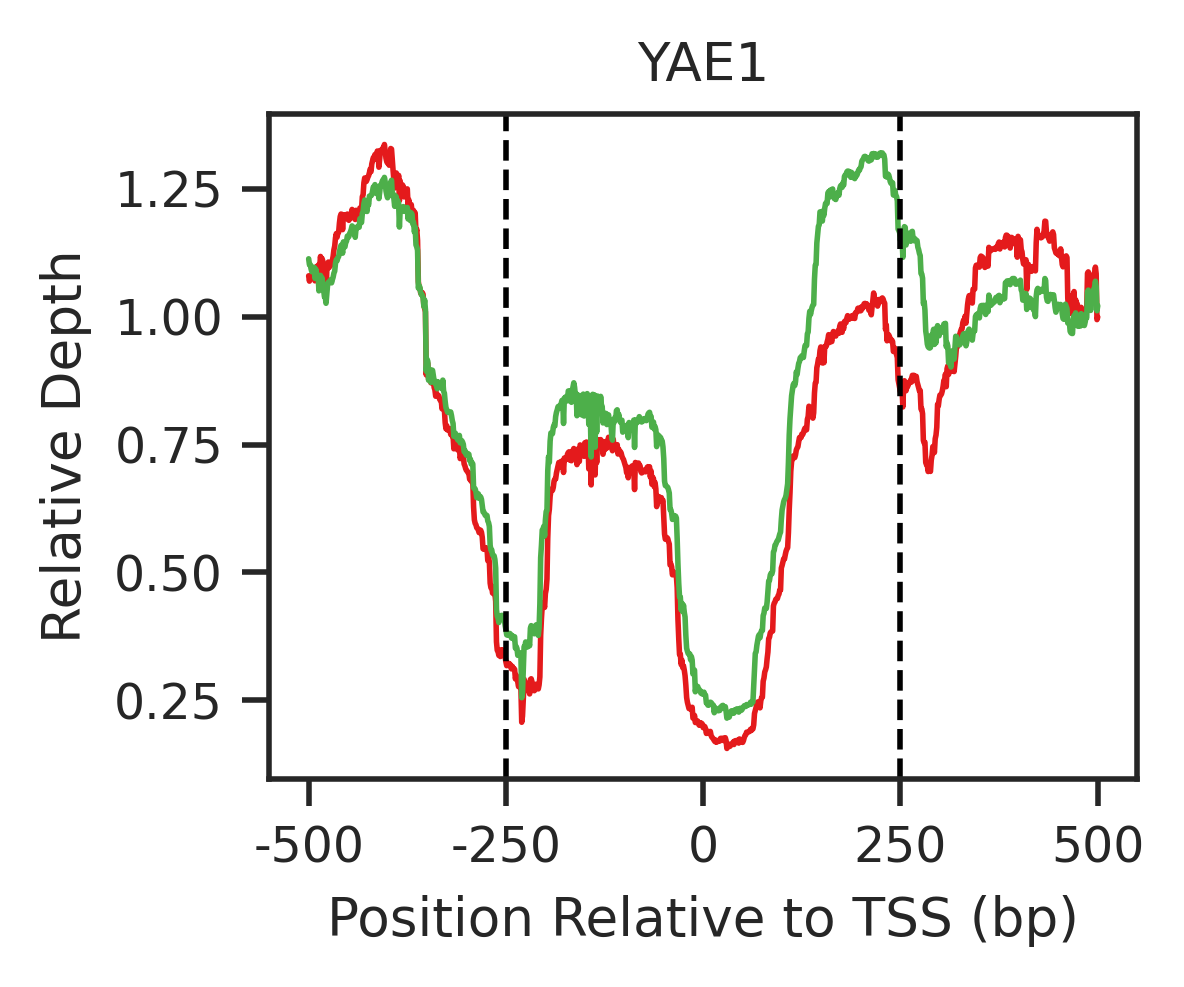

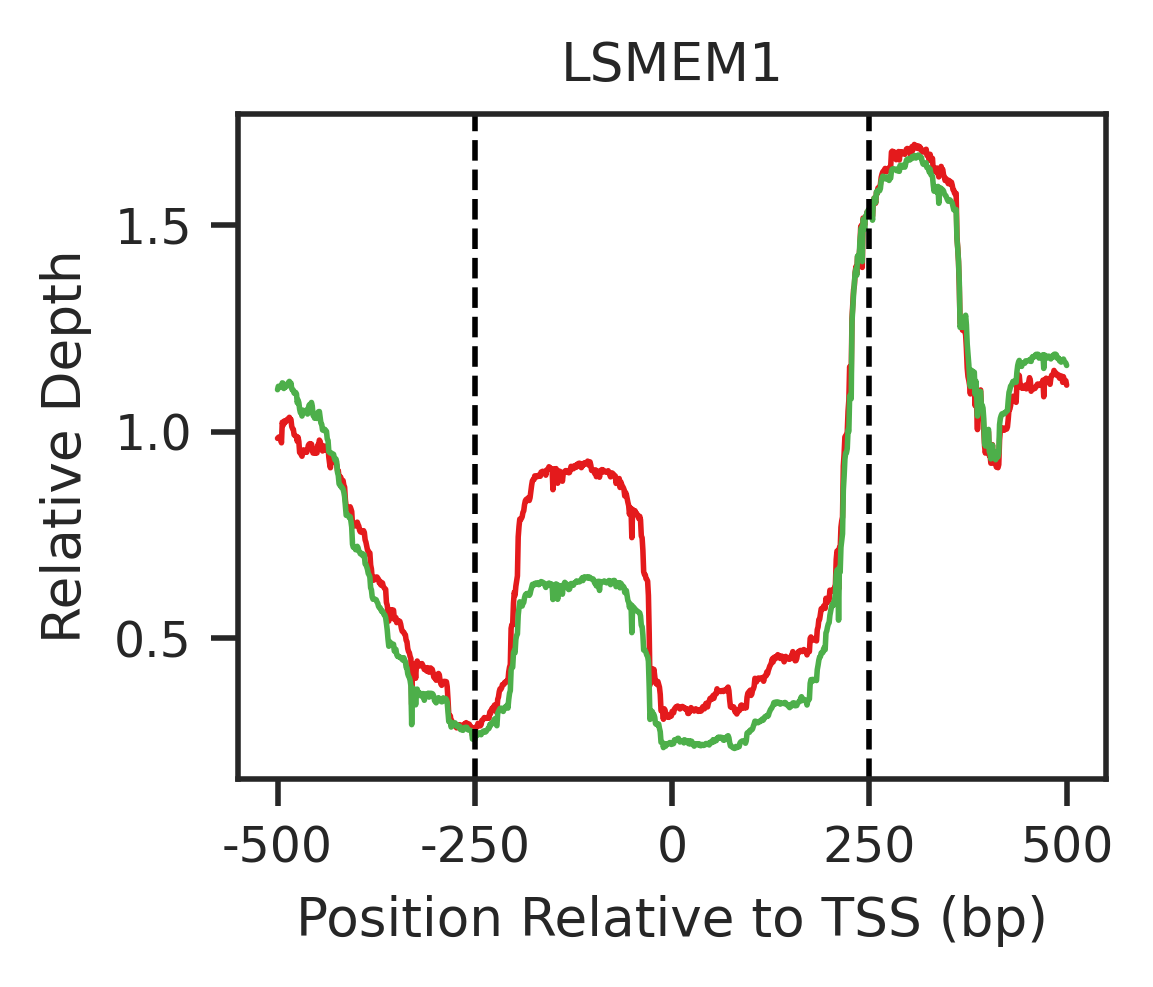

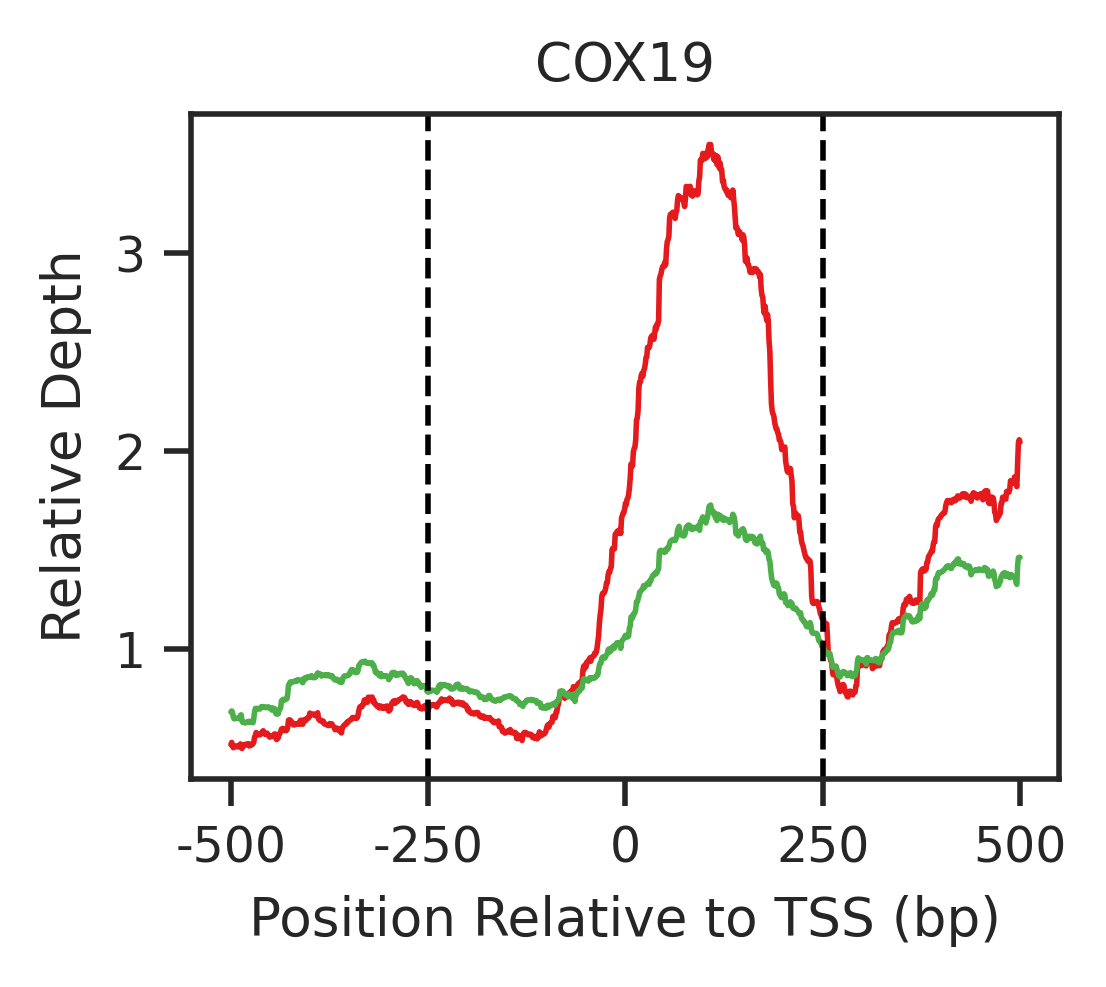

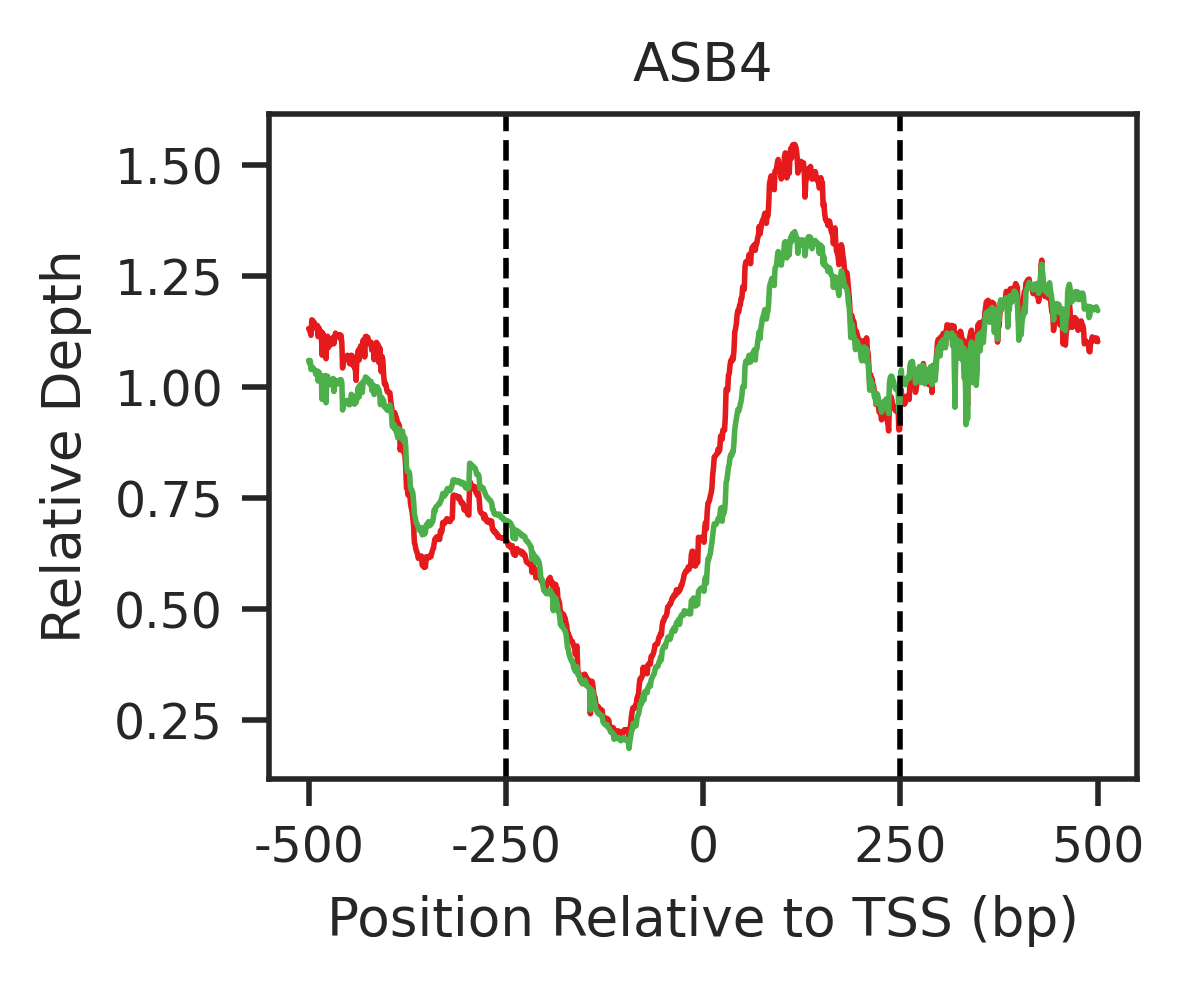

In [24]:
n_feat_tss = len(tss_names)

for iddd, i_tss in enumerate(tss_names):
    
    fig, axs = plt.subplots(1,1, figsize=(2.8,2.2))

    gene_name = tss_gene_df.loc[tss_gene_df['tss']==i_tss, 'gene'].values[0]
    
    p_tss_cov = tss_cov_dat[tss_cov_dat['gene']==i_tss].copy()
    p_tss_cov.sort_values(by='site', inplace=True)
    p_tss_cov = p_tss_cov.iloc[:,4:].T.copy()
    p_tss_cov['ind']=p_tss_cov.index
    p_tss_cov.reset_index(drop=True, inplace=True)
    p_tss_cov_info = p_tss_cov.merge(pat_info, on='ind')
    p_tss_cov_info_avg_depth = p_tss_cov_info.merge(reads_avg_depth_df, on='ind')
    p_tss_cov_info_avg_depth.iloc[:,:-3] = p_tss_cov_info_avg_depth.iloc[:,:-3].div(p_tss_cov_info_avg_depth['avg_depth'], axis=0)
    
    criticals = []
    non_criticals =[]

    for index, row in p_tss_cov_info_avg_depth.iterrows():
        i_dat1 = row[:-3].values
        # divided by flank depth
        over_avg = i_dat1[list(np.arange(0,250))+list(np.arange(750,1000))].mean()
        if over_avg == 0:
            over_avg = i_dat1.mean()
        i_dat =i_dat1/over_avg
        
        if row['new_triage'] == 1:
            color = "#e41a1c"
            criticals.append(i_dat)
            alpha=0.04
        else:
            color = "#4daf4a"
            non_criticals.append(i_dat)
            alpha=0.02
        # axs[iddd].plot(np.arange(-500,501), i_dat, c=color, alpha=alpha, lw=0.3)
    
    axs.plot(np.arange(-500,501),np.mean(criticals,axis=0), c="#e41a1c",lw=1,label='Critical')
    axs.plot(np.arange(-500,501),np.mean(non_criticals,axis=0), c="#4daf4a",lw=1,label='Noncritical')
    axs.set_xticks([-500,-250,0,250,500])
    axs.set_title(gene_name)
    axs.set_ylabel('Relative Depth')
    axs.set_xlabel('Position Relative to TSS (bp)')
    axs.axvline(x = 250, ls='--', lw=1, c='black')
    axs.axvline(x = -250, ls='--', lw=1,c='black')

    plt.savefig("results_plt/raw_data_tss_cov_m2model_{}.pdf".format(gene_name), dpi=400, bbox_inches='tight', format='pdf')

In [18]:

p_tss_cov = tss_cov_dat[tss_cov_dat['gene']=='gene_0_37969'].copy()
p_tss_cov.sort_values(by='site', inplace=True)
p_tss_cov = p_tss_cov.iloc[:,4:].T.copy()
p_tss_cov['ind']=p_tss_cov.index
p_tss_cov.reset_index(drop=True, inplace=True)
p_tss_cov_info = p_tss_cov.merge(pat_info, on='ind')
p_tss_cov_info_avg_depth = p_tss_cov_info.merge(reads_avg_depth_df, on='ind')
p_tss_cov_info_avg_depth.iloc[:,:-3] = p_tss_cov_info_avg_depth.iloc[:,:-3].div(p_tss_cov_info_avg_depth['avg_depth'], axis=0)

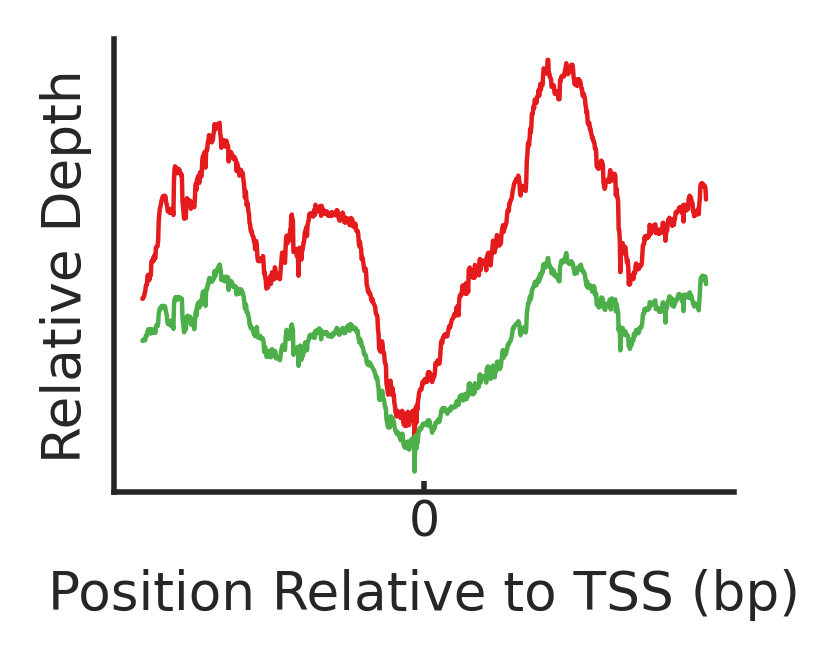

In [97]:
fig, ax = plt.subplots(1,1, figsize=(2,1.5))
criticals = []
non_criticals =[]

for index, row in p_tss_cov_info_avg_depth.iterrows():
    i_dat = row[:-3].values
    if row['new_triage'] == 1:
        color = "#e41a1c"
        criticals.append(i_dat)
        alpha=0.04
    else:
        color = "#4daf4a"
        non_criticals.append(i_dat)
        alpha=0.04
    # ax.plot(np.arange(-500,501), i_dat, c=color, alpha=alpha, lw=0.5)
    
ax.plot(np.arange(-500,501),np.mean(criticals,axis=0), c="#e41a1c",lw=0.8,label='Noncritical')
ax.plot(np.arange(-500,501),np.mean(non_criticals,axis=0), c="#4daf4a",lw=0.8,label='Critical')
ax.set_xticks([-500,-250,0,250,500])
# ax.set_xlim(-260,260)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([0])
ax.set_ylabel('Relative Depth')
ax.set_xlabel('Position Relative to TSS (bp)')
ax.tick_params(direction='in', length=2,pad=1)

plt.savefig("results_plt/raw_data_tss_cov_demo.pdf", dpi=400, bbox_inches='tight')

/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator


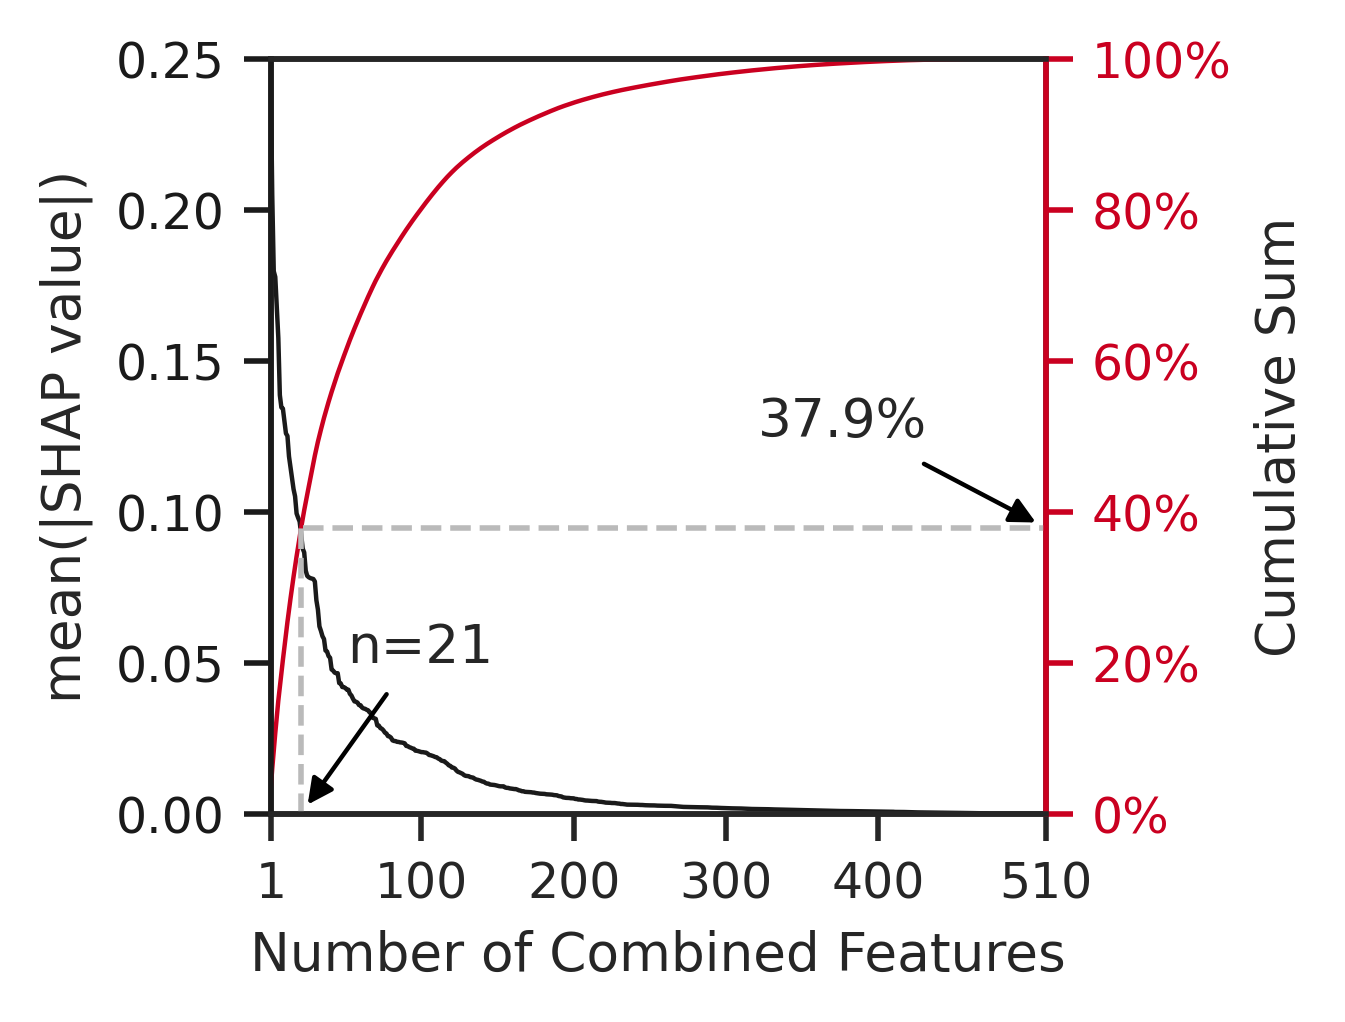

In [31]:
i_feat_type='m2model'
m2model_all_shap = load_feat_importance_shap(i_feat_type, return_all=True)

mean_shaps = m2model_all_shap['feat_shap_mean'].values
mean_shap_cumsum = np.cumsum(mean_shaps)/mean_shaps.sum()

fig, ax1 = plt.subplots(1,1,figsize=(2.5,2.5))

ax1.plot(range(m2model_all_shap.shape[0]), m2model_all_shap['feat_shap_mean'].values, c='k', lw = 0.8)
ax1.tick_params(axis='y', colors='k')
ax1.set_ylim(0,0.25)
ax1.set_xlim(0,509)

ax2 = ax1.twinx()
ax2.plot(range(m2model_all_shap.shape[0]), mean_shap_cumsum, c='#ca0020', lw = 0.8)
ax2.tick_params(axis='y', colors='#ca0020')
ax2.spines['right'].set_color('#ca0020')
ax2.spines['left'].set_color('k')
ax2.set_ylim(0,1)
ax2.axvline(x = 20,ymax=mean_shap_cumsum[20], ls='--', lw=1, c='#bababa')
ax2.axhline(y=mean_shap_cumsum[20],xmin=21/510, ls='--', lw=1, c='#bababa')
# ax2.plot([20, 50], [0, 0.05], color='k', linestyle='-', lw=0.5)
# ax2.text(25, 0.05, 'n=21', fontsize=8)
ax2.annotate("n=21", xy=(20, 0), xytext=(50, 0.2), arrowprops=dict(arrowstyle="-|>",color='black'))

ax2.annotate("{:.1f}%".format(mean_shap_cumsum[20]*100), 
             xy=(509, mean_shap_cumsum[20]), xytext=(320, 0.50), arrowprops=dict(arrowstyle="-|>",color='black'))

ax1.set_xlabel('Number of Combined Features')
ax1.set_ylabel('mean(|SHAP value|)')
# ax1.yaxis.label.set_color('red')
ax2.set_ylabel('Cumulative Sum')
# ax2.yaxis.label.set_color('blue')

steps = 100
x_tick = [0] + list(range(steps-1, mean_shap_cumsum.shape[0],steps)) 
x_tick[-1] = mean_shap_cumsum.shape[0]-1
ax2.set_xticks(x_tick)
xtick_lab = np.array(x_tick)+1
ax2.set_xticklabels(xtick_lab) 

ax2.set_yticklabels(['{}%'.format(int(x*100)) for x in ax2.get_yticks()]) 

plt.savefig("results_plt/feat_importance_cumsum_{}_n{}.pdf".format(i_feat_type, m2model_all_shap.shape[0]), dpi=400, bbox_inches='tight')

In [10]:

max_feat_idx_ap = {'lab': 14, 'fragl': 6, 'tss': 31, 'motif': 28, 'm2model': 20}
i_feat_type = 'm2model'

i_re_perf_fname = os.path.join(model_re_root_dir, '{}/32_fl_entire_feat_retrain-auc.pkl'.format(i_feat_type))
with open(i_re_perf_fname, 'rb') as f:
    perf_feats = pickle.load(f)
    
# i_re = perf_feats[0]
preds_df = []
for n_idx, i_re in enumerate(perf_feats): 
    # https://github.com/slundberg/shap/issues/632
    shap_values_t = i_re[3] # shap values)
    preds_df.append(pd.concat([i_re[2], pd.DataFrame(shap_values_t, columns=i_re[0].feature_name())], axis=1))
all_tmp_preds_df = pd.concat(preds_df)
f_pred_df = all_tmp_preds_df.groupby('ind').mean()
f_pred_df.reset_index(level=0, inplace=True)
tmp=f_pred_df.copy()
f_pred_df['sum_abs_shap_lab']=tmp.iloc[:,3:62+3].abs().sum(1)/tmp.iloc[:,3:].abs().sum(1)
f_pred_df['sum_abs_shap_fragl']=tmp.iloc[:,62+3:62+3+15].abs().sum(1)/tmp.iloc[:,3:].abs().sum(1)
f_pred_df['sum_abs_shap_tss']=tmp.iloc[:,62+3+15:62+3+15+177].abs().sum(1)/tmp.iloc[:,3:].abs().sum(1)
f_pred_df['sum_abs_shap_motif']=tmp.iloc[:,62+3+15+177:].abs().sum(1)/tmp.iloc[:,3:].abs().sum(1)


/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/distributed/config.py:63: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config.update(yaml.load(text) or {})


In [ ]:
f_pred_df.head()

In [12]:
m2model_feats = load_feat_importance_shap('m2model')['feat_name'].values
featnames = load_all_feats_name()
f_type=[]
for f in m2model_feats:
    for iiidx, t in enumerate('lab,fragl,tss,motif'.split(',')):
        if f in featnames[t]:
            f_type.append(t)
            break

f_type = np.array(f_type)

/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


### Plot Contribution

/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator


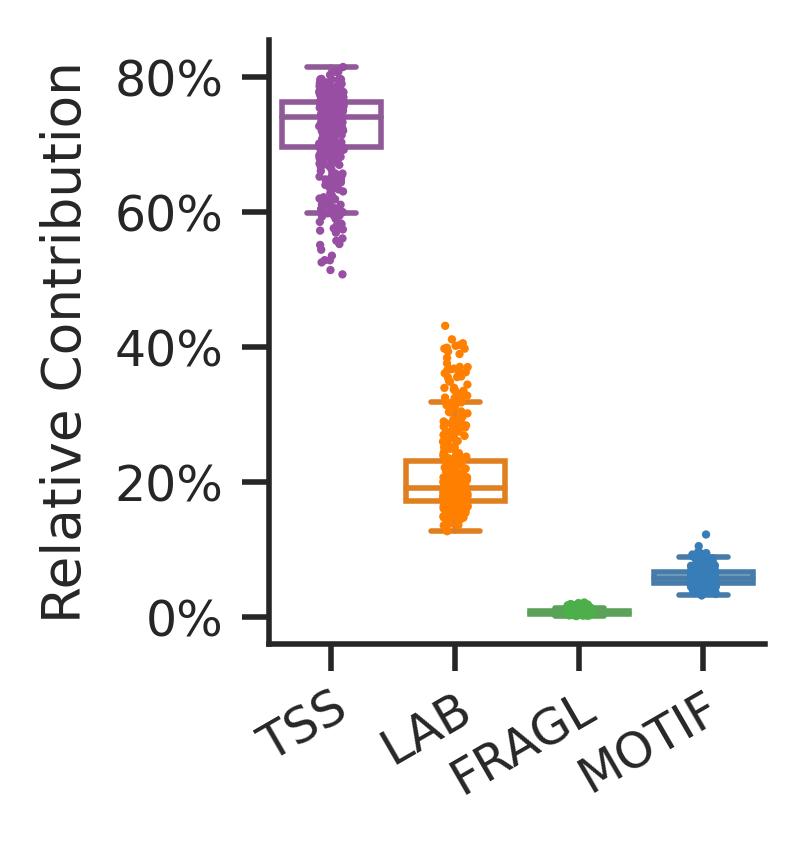

In [127]:
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu

#
# https://stats.stackexchange.com/questions/501039/can-i-scale-and-then-interpret-shap-values-as-percent-contribution-to-the-predic
#
ds_contrib_df = pd.concat([pd.DataFrame({'feats':['LAB']*f_pred_df.shape[0], 'contrib':f_pred_df['sum_abs_shap_lab'].values}),
                          pd.DataFrame({'feats':['FRAGL']*f_pred_df.shape[0], 'contrib':f_pred_df['sum_abs_shap_fragl'].values}),
                          pd.DataFrame({'feats':['TSS']*f_pred_df.shape[0], 'contrib':f_pred_df['sum_abs_shap_tss'].values}),
                          pd.DataFrame({'feats':['MOTIF']*f_pred_df.shape[0], 'contrib':f_pred_df['sum_abs_shap_motif'].values})])

orders = ['TSS','LAB', 'FRAGL', 'MOTIF']

palette = {'TSS':'#984ea3','LAB':'#ff7f00', 'FRAGL':'#4daf4a', 'MOTIF':'#377eb8'}

fig, axs = plt.subplots(1,1, figsize=(1.6,2))

plot_param={
    'data':ds_contrib_df,
    'x':'feats',
    'y':'contrib',
    'order':orders,
    'orient':'v'
}

sns.stripplot(**plot_param, ax=axs,palette=palette,size=1.5)
axa = sns.boxplot(**plot_param,ax=axs,palette=palette, showfliers=False, linewidth=1,width=0.8)
for i,artist in enumerate(axa.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*5,i*5+5):
        line = axa.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

# tss_values = ds_contrib_df.loc[ds_contrib_df['feats']==orders[0],'contrib'].values
# lab_values = ds_contrib_df.loc[ds_contrib_df['feats']==orders[1],'contrib'].values
# fragl_values = ds_contrib_df.loc[ds_contrib_df['feats']==orders[2],'contrib'].values
# motif_values = ds_contrib_df.loc[ds_contrib_df['feats']==orders[3],'contrib'].values

# pvalues = [
#     mannwhitneyu(tss_values, lab_values, alternative="two-sided").pvalue,
#     mannwhitneyu(tss_values, fragl_values, alternative="two-sided").pvalue,
#     mannwhitneyu(tss_values, motif_values, alternative="two-sided").pvalue
# ]
# formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

# anno_pairs= [(orders[0], orders[1]),(orders[0], orders[2]),(orders[0], orders[3])]
# annot = Annotator(axa, pairs=anno_pairs, **plot_param)
# annot.reset_configuration()
# annot.set_custom_annotations(formatted_pvalues)
# annot.configure(verbose=False,line_width=1.2,fontsize=8,loc='inside',line_height=0, text_offset=1)
# annot.annotate(line_offset=0.01)

axa.set_xlabel('')
axa.set_yticklabels(['{}%'.format(int(x*100)) for x in axa.get_yticks()]) 
axa.set_ylabel('Relative Contribution')
sns.despine()
xticklabels = axa.set_xticklabels(axa.get_xticklabels(),rotation=30, ha='right',rotation_mode="anchor")
for i, xticklabel in enumerate(xticklabels):
    xticklabel.set_y(xticklabel.get_position()[1] +  0.01)

plt.savefig("results_plt/feat_dataset_distribution.pdf", dpi=400, bbox_inches='tight')


### LAB Feature analysis

In [13]:
labs_names = m2model_feats[f_type=='lab']
lab_units = dict(zip(['LDH', 'Uric_acid', 'α-HBDH', 'PA'],['U/L','μmol/L','U/L','mg/L']))
print(labs_names)

# load raw lab data
lab_raw_dat = pd.read_csv(os.path.join(raw_data_dir, '399_labtest_fill.csv'))
imp_feat_data = lab_raw_dat[['ind','new_triage']+labs_names.tolist()].copy()

lab_shap_value = f_pred_df[['ind','new_triage']+labs_names.tolist()].copy()

shap_data_values = imp_feat_data.merge(lab_shap_value, on=['ind','new_triage'])

shap_data_values['labels']=shap_data_values['new_triage'].apply(lambda x: 'Noncritical' if x ==0 else 'Critical')

orders = ['Noncritical','Critical']
palette = dict(zip(orders, ['#2ecc71','#e74c3c']))


['LDH' 'Uric_acid' 'α-HBDH' 'PA']


In [ ]:
shap_data_values

In [ ]:
fp_high_risk_pit = [str(x[2:]) for x in ['PU8811', 'PU1463', 'PU8151', 'PU6778', 'PU7436', 'PU8494', 'PU8354']]
shap_data_values[shap_data_values['ind'].str.slice(start=5,stop=9).isin(fp_high_risk_pit)]

In [ ]:
shap_data_values[shap_data_values['ind'].str.slice(start=5,stop=9)=='8354']

#### Analysis based on SHAP

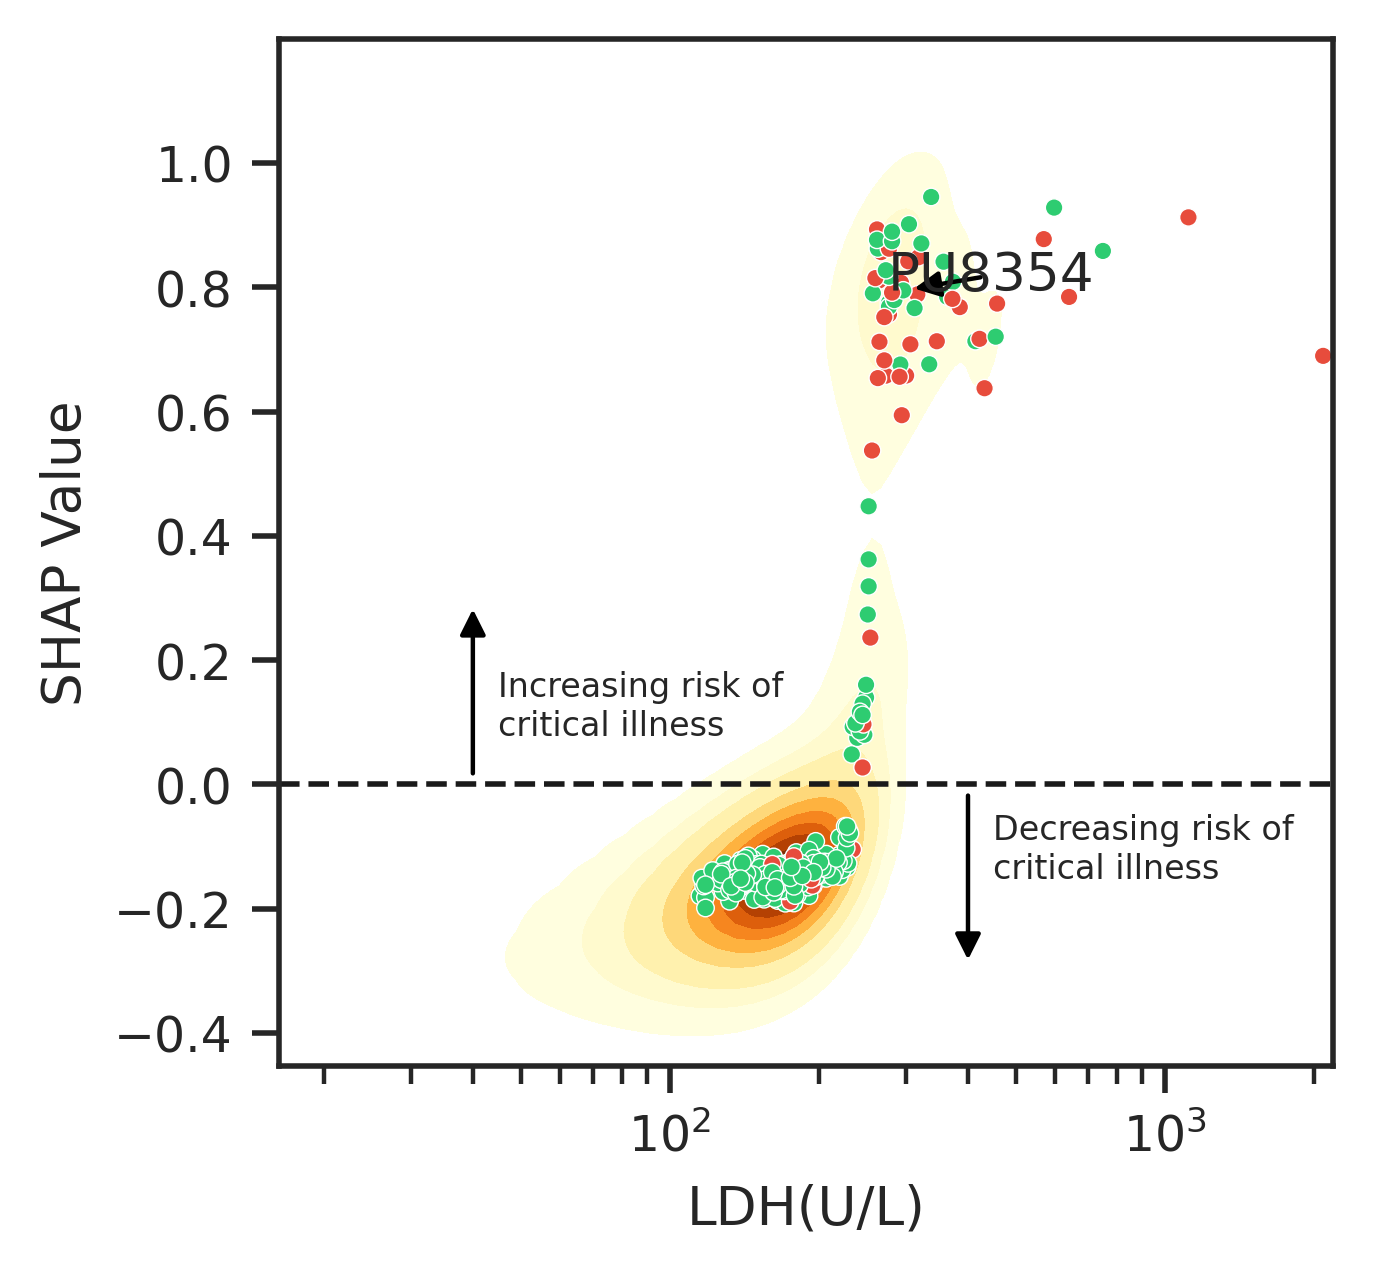

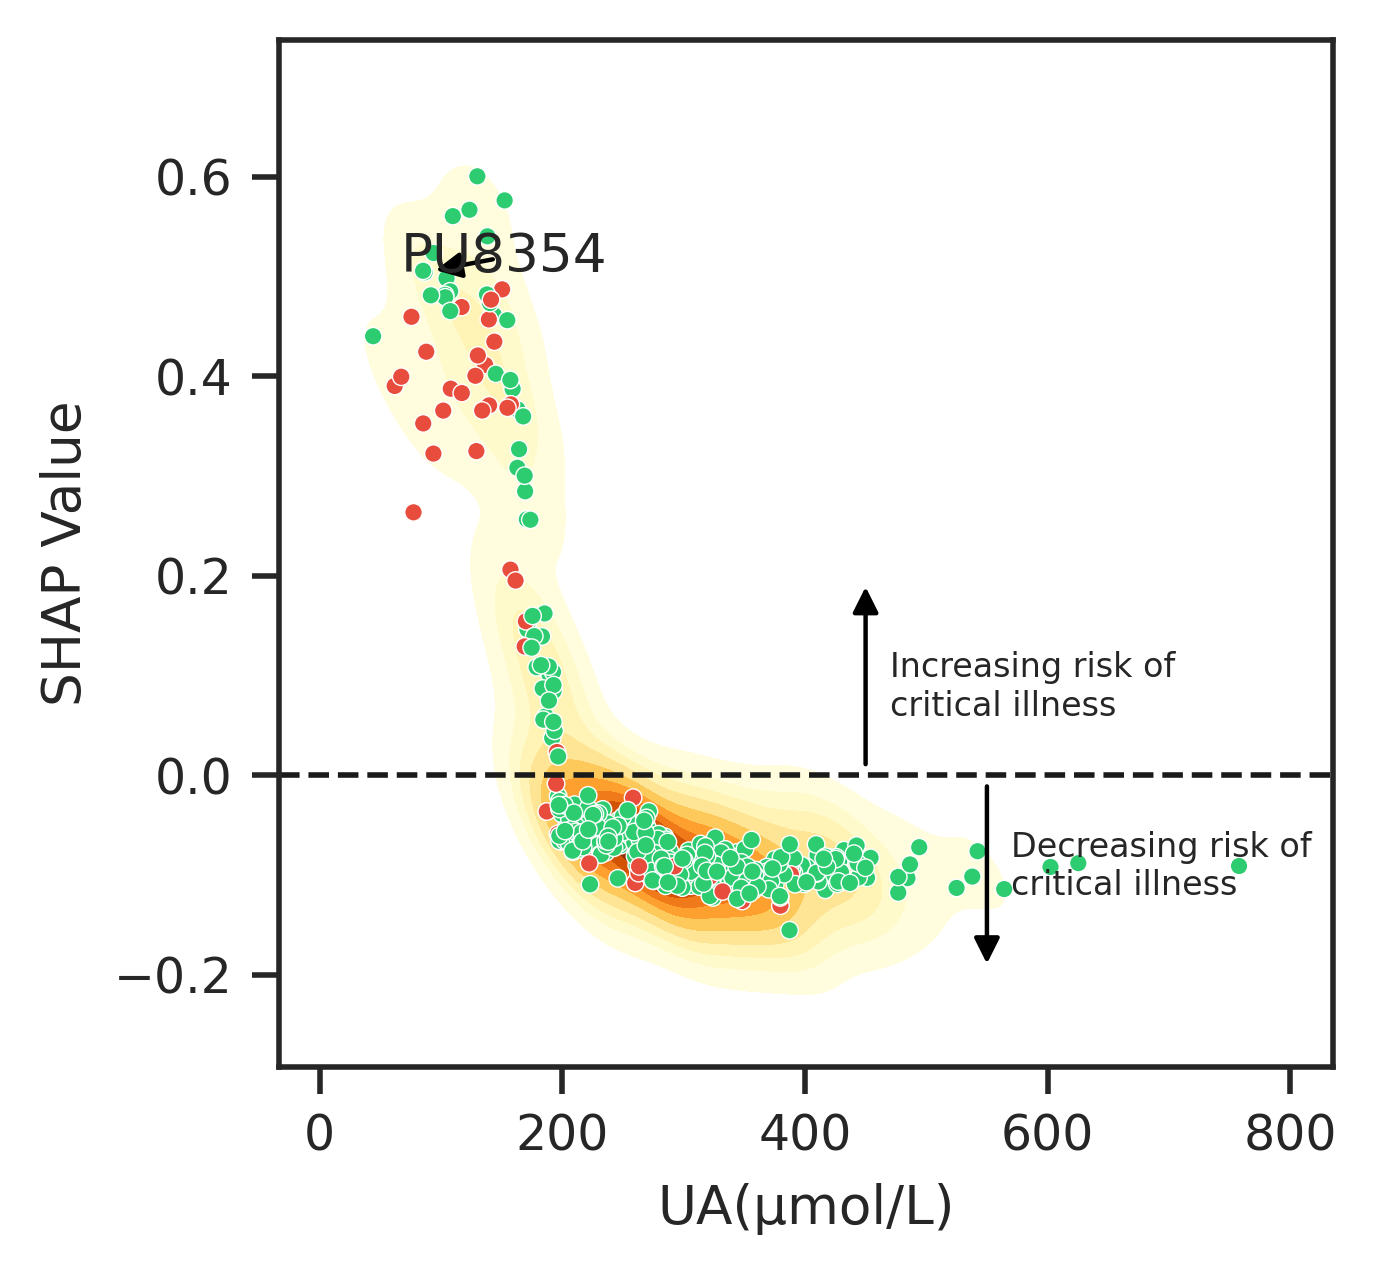

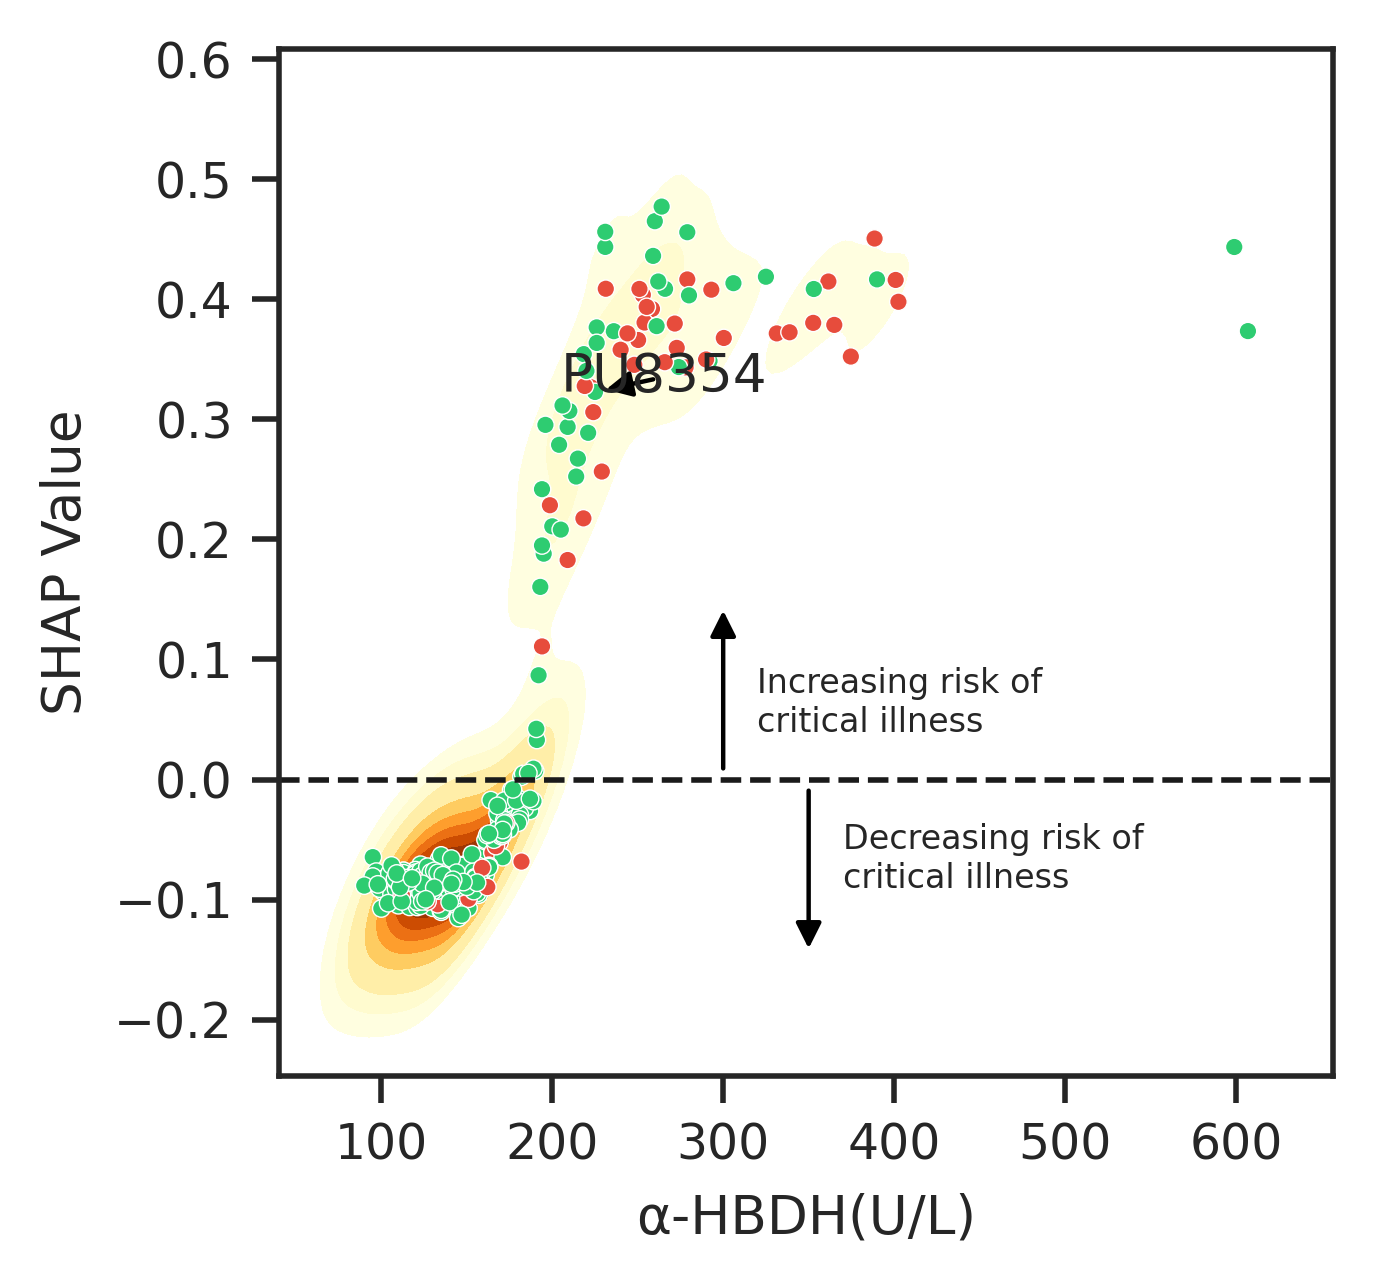

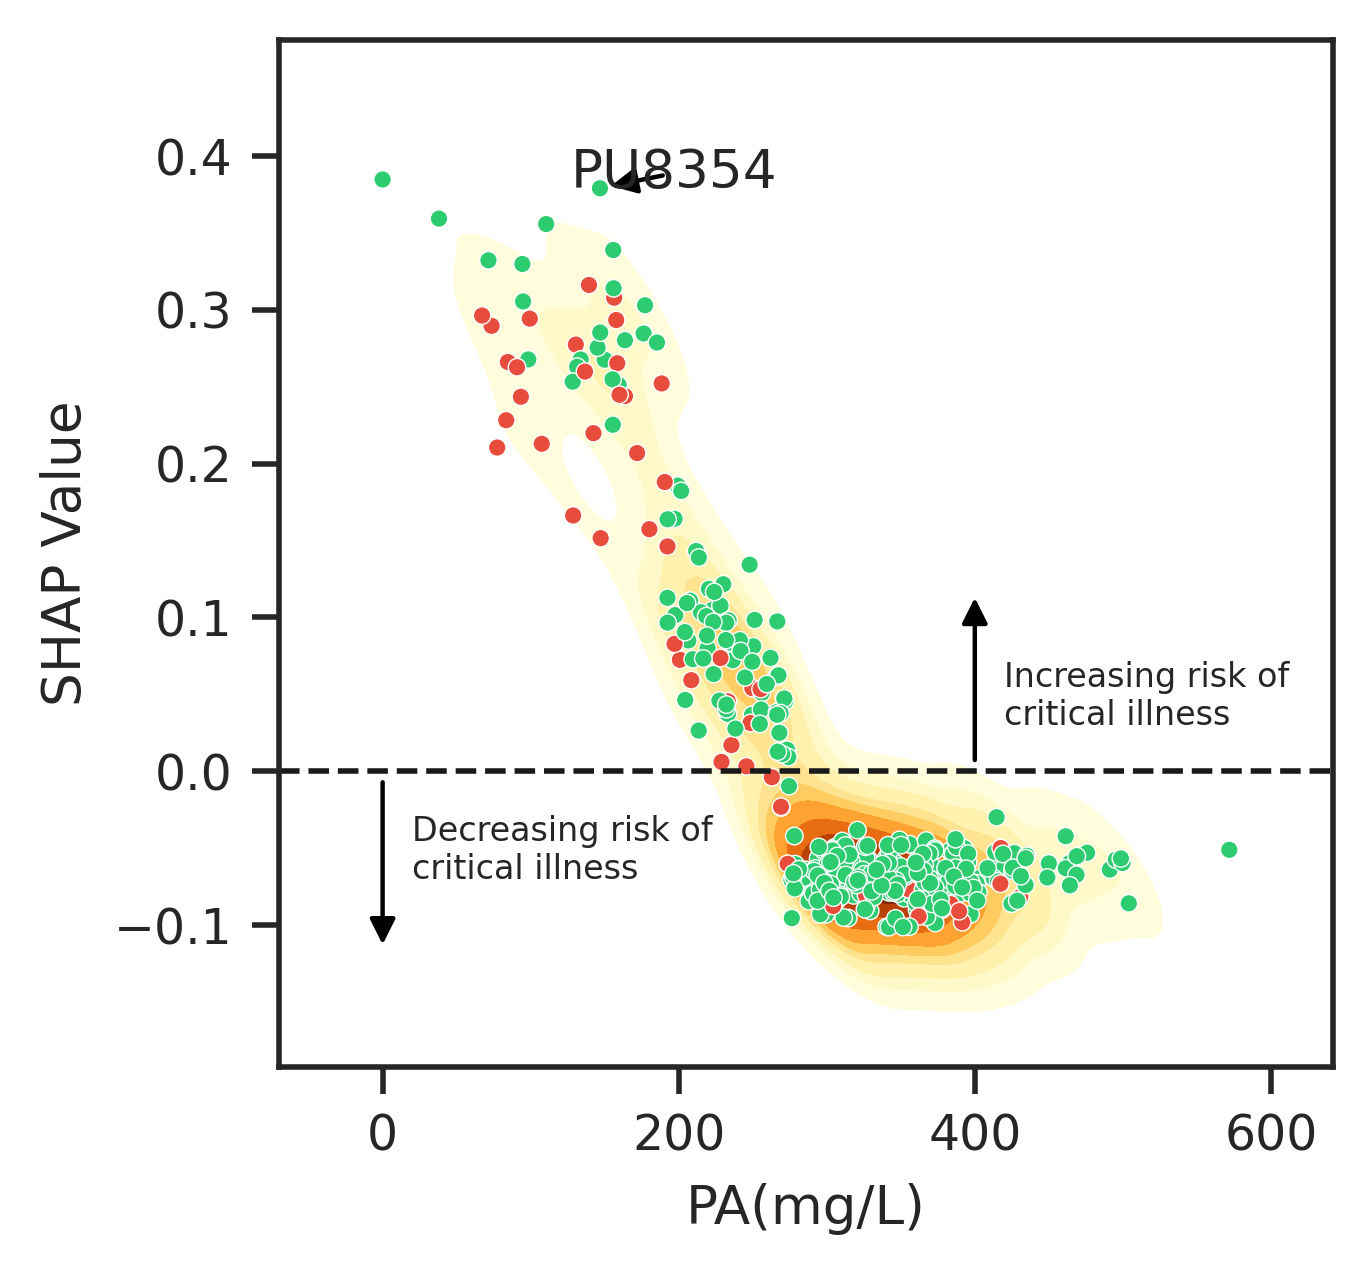

In [34]:
# plot
pid='8354'
for i_lab_name in labs_names:
    
    fig, ax1 = plt.subplots(1,1,figsize=(3.4,3.4))
    sns.kdeplot(x=shap_data_values['{}_x'.format(i_lab_name)], 
                y=shap_data_values['{}_y'.format(i_lab_name)], cmap="YlOrBr", shade=True, bw_adjust=.7,ax=ax1)
    sns.scatterplot(data=shap_data_values, x='{}_x'.format(i_lab_name), 
                    y='{}_y'.format(i_lab_name),edgecolors=None,
                    hue="labels",palette=palette, ax=ax1,s=10)
    
    fp_high_risk_exam = shap_data_values[shap_data_values['ind'].str.slice(start=5,stop=9)==pid]
    
    ax1.annotate("PU{}".format(pid), 
                 xy=(fp_high_risk_exam['{}_x'.format(i_lab_name)], fp_high_risk_exam['{}_y'.format(i_lab_name)]),
                 xytext=(fp_high_risk_exam['{}_x'.format(i_lab_name)]-20, fp_high_risk_exam['{}_y'.format(i_lab_name)]),
                 arrowprops=dict(arrowstyle="-|>",color='black'))
    
    ax1.axhline(y=0, ls='--', lw=1,c='k')
    
    if i_lab_name == 'LDH':
        ax1.set_xscale('log')
    ax1.set_ylabel('SHAP Value')
    
    if i_lab_name == 'Uric_acid':
        ax1.set_xlabel('UA({})'.format(lab_units[i_lab_name]))
    else:
        ax1.set_xlabel(i_lab_name+'({})'.format(lab_units[i_lab_name]))
        
    # 
    if i_lab_name == 'LDH':
        ax1.annotate("", xy=(40, 0), xytext=(40, 0.3), arrowprops=dict(arrowstyle="<|-",color='black'))
        ax1.annotate("", xy=(400, 0), xytext=(400, -0.3), arrowprops=dict(arrowstyle="<|-",color='black'))
        ax1.text(45, 0.08, 'Increasing risk of\ncritical illness', fontsize=6)
        ax1.text(450, -0.15, 'Decreasing risk of\ncritical illness', fontsize=6)
    elif i_lab_name == 'Uric_acid':
        ax1.annotate("", xy=(450, 0), xytext=(450, 0.2), arrowprops=dict(arrowstyle="<|-",color='black'))
        ax1.annotate("", xy=(550, 0), xytext=(550, -0.2), arrowprops=dict(arrowstyle="<|-",color='black'))
        ax1.text(470, 0.06, 'Increasing risk of\ncritical illness', fontsize=6)
        ax1.text(570, -0.12, 'Decreasing risk of\ncritical illness', fontsize=6)
    elif i_lab_name == 'α-HBDH':
        ax1.annotate("", xy=(300, 0), xytext=(300, 0.15), arrowprops=dict(arrowstyle="<|-",color='black'))
        ax1.annotate("", xy=(350, 0), xytext=(350, -0.15), arrowprops=dict(arrowstyle="<|-",color='black'))
        ax1.text(320, 0.04, 'Increasing risk of\ncritical illness', fontsize=6)
        ax1.text(370, -0.09, 'Decreasing risk of\ncritical illness', fontsize=6)
    else:
        ax1.annotate("", xy=(400, 0), xytext=(400, 0.12), arrowprops=dict(arrowstyle="<|-",color='black'))
        ax1.annotate("", xy=(0, 0), xytext=(0, -0.12), arrowprops=dict(arrowstyle="<|-",color='black'))
        ax1.text(420, 0.03, 'Increasing risk of\ncritical illness', fontsize=6)
        ax1.text(20, -0.07, 'Decreasing risk of\ncritical illness', fontsize=6)
    
    ax1.get_legend().remove()
    plt.savefig("results_plt/feat_shap_values_{}.pdf".format(i_lab_name), dpi=400, bbox_inches='tight')


#### Analysis Based on Read Values

/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/statannotations/Annotator.py:795: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/statannotations/Annotator.py:795: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/statannotations/Annotator.py:795: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/statannotations/Annotator.py:7

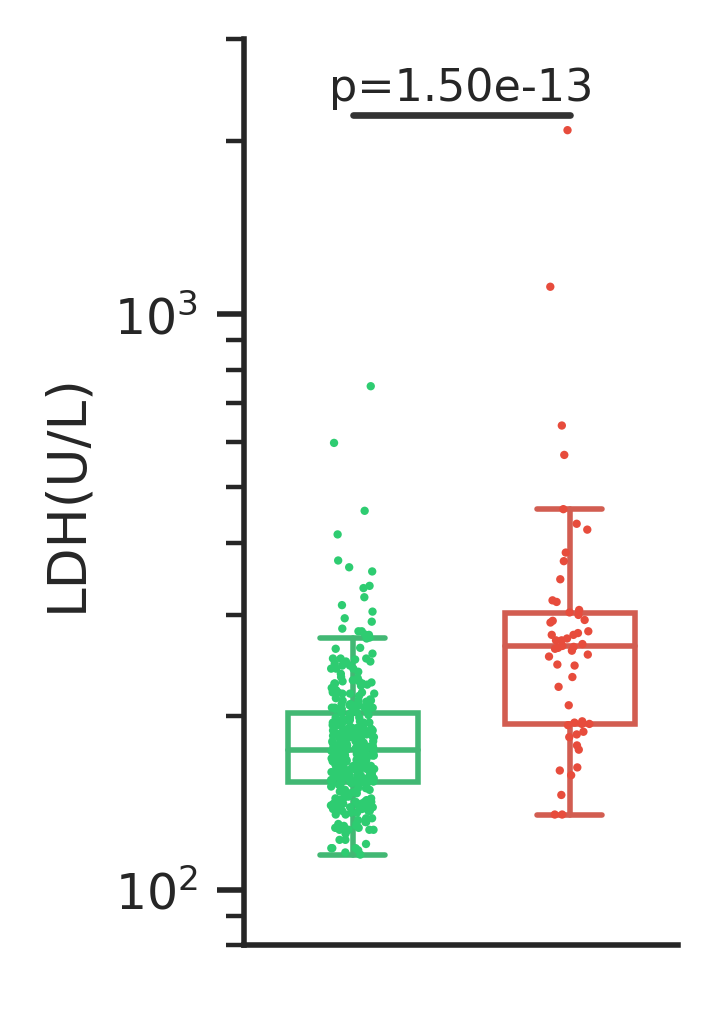

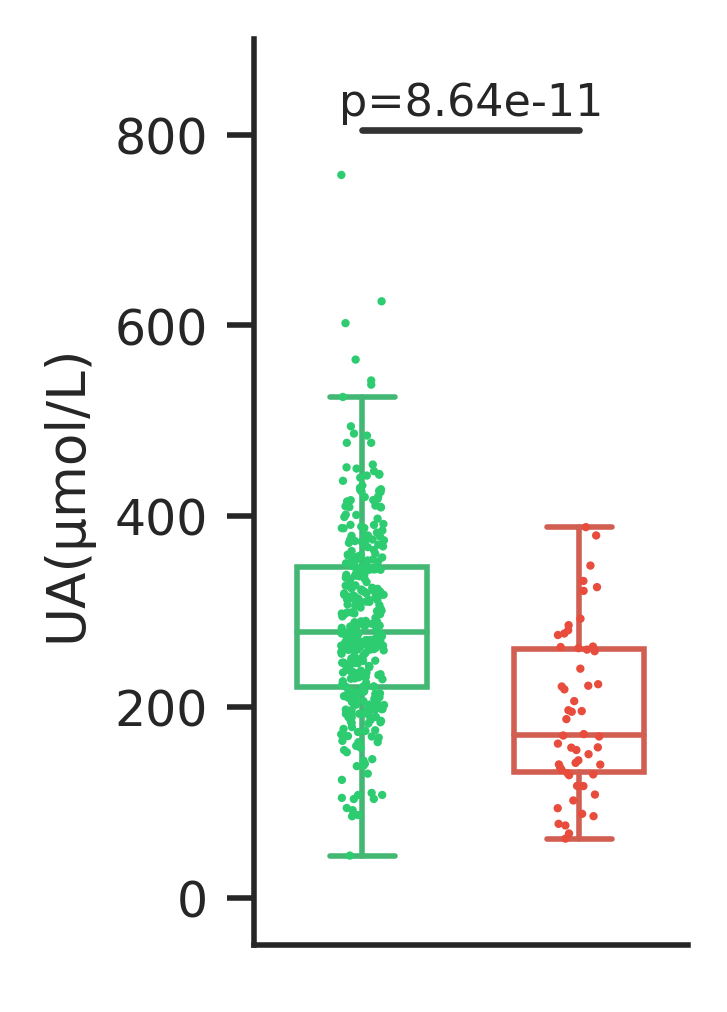

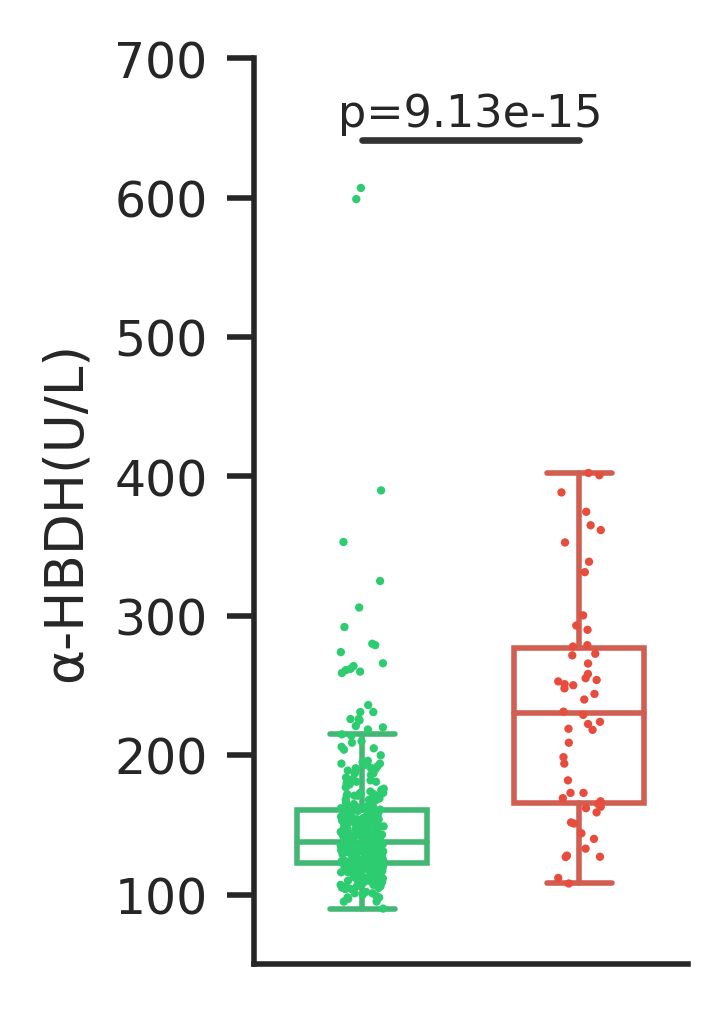

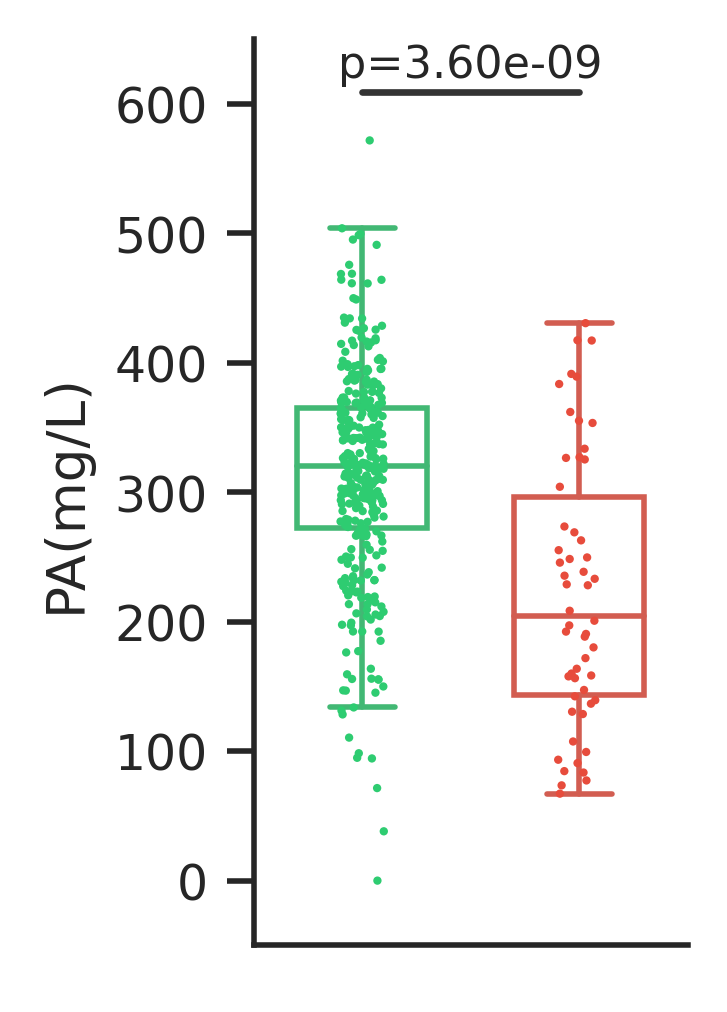

In [73]:
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu

# fig, axs = plt.subplots(1,len(i_feats_name), figsize=(6.8,2))
orders = ['Noncritical','Critical']
palette = dict(zip(orders, ['#2ecc71','#e74c3c']))

for ix in range(len(labs_names)):
    
    fig, axs = plt.subplots(1,1,figsize=(1.4,3))

    plot_param={
        'data':shap_data_values,
        'x':'labels',
        'y':labs_names[ix]+'_x',
        'order':orders,
        'orient':'v'
    }

    sns.stripplot(**plot_param, ax=axs,palette=palette,size=1.5)
    axa = sns.boxplot(**plot_param,ax=axs,palette=palette, showfliers=False, linewidth=1,width=0.6)

    for i,artist in enumerate(axs.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*5,i*5+5):
            line = axa.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    noncri_values = shap_data_values.loc[shap_data_values['labels']=='Noncritical',
                                  labs_names[ix]+'_x'].values
    cri_values = shap_data_values.loc[shap_data_values['labels']=='Critical',
                               labs_names[ix]+'_x'].values

    pvalues=[mannwhitneyu(noncri_values, cri_values, alternative="two-sided").pvalue]

    formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

    anno_pairs= [(orders[0], orders[1])]
    annot = Annotator(axa, pairs=anno_pairs, **plot_param)
    annot.reset_configuration()
    annot.set_custom_annotations(formatted_pvalues)
    annot.configure(verbose=False,line_width=1.2,fontsize=8,loc='inside',line_height=0, text_offset=1)
    annot.annotate()
    if labs_names[ix]=='LDH':
        axa.set_yscale('log') 
        axa.set_ylim((80,3000))
    elif labs_names[ix]=='Uric_acid': 
        axa.set_ylim((-50,900))
    elif labs_names[ix]=='α-HBDH': 
        axa.set_ylim((50,700))
    else:
        axa.set_ylim((-50,650))
    
    axa.set_ylabel('UA('+lab_units[labs_names[ix]]+')' \
                   if labs_names[ix]=='Uric_acid' else labs_names[ix]+'('+lab_units[labs_names[ix]]+')')
    axa.set_xlabel(None)
    axa.set_xticks([])

    # axa.set_xticklabels(axa.get_xticklabels(),rotation=30, ha='right')
    sns.despine()
    plt.savefig("results_plt/feat_real_dist_{}.pdf".format(labs_names[ix]), dpi=400, bbox_inches='tight')

### TSS Feature analysis

In [27]:
# get TSS features
tss_names = m2model_feats[f_type=='tss']
tss_raw_dat_fname = os.path.join(raw_data_dir, 'tss.fillna.pkl')

with open(tss_raw_dat_fname, 'rb') as f:
    tss_raw_dat = pickle.load(f)[['ind','label']+tss_names.tolist()].copy()
    
tss_raw_dat.rename(columns={"label": "new_triage"}, inplace=True)
tss_raw_dat['labels']=tss_raw_dat['new_triage'].apply(lambda x: 'Noncritical' if x ==0 else 'Critical')

genes = [tss_gene_df.loc[tss_gene_df['tss']==x, 'gene'].values[0] for x in tss_names]
geness = ['DEFA1' if x == 'DEFA1B,DEFA1' else x for x in genes] 
tss_genes_map = dict(zip(tss_names, geness))
tss_raw_dat.rename(columns=tss_genes_map, inplace=True)

In [ ]:
tss_raw_dat.head()

/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/statannotations/Annotator.py:795: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/statannotations/Annotator.py:795: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/statannotations/Annotator.py:795: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/zfssz2/ST_MCHRI/BIGDATA/USER/baiyong/anaconda3/lib/python3.6/site-packages/statannotations/Annotator.py:7

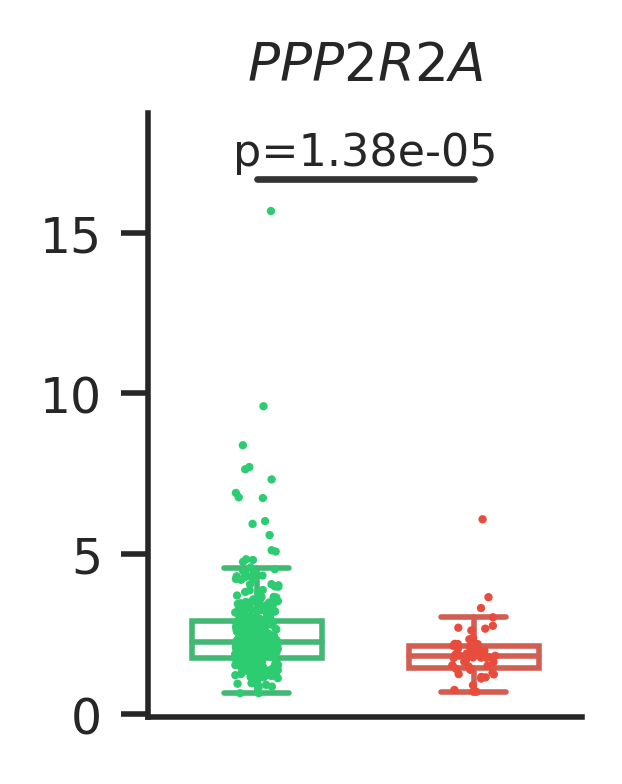

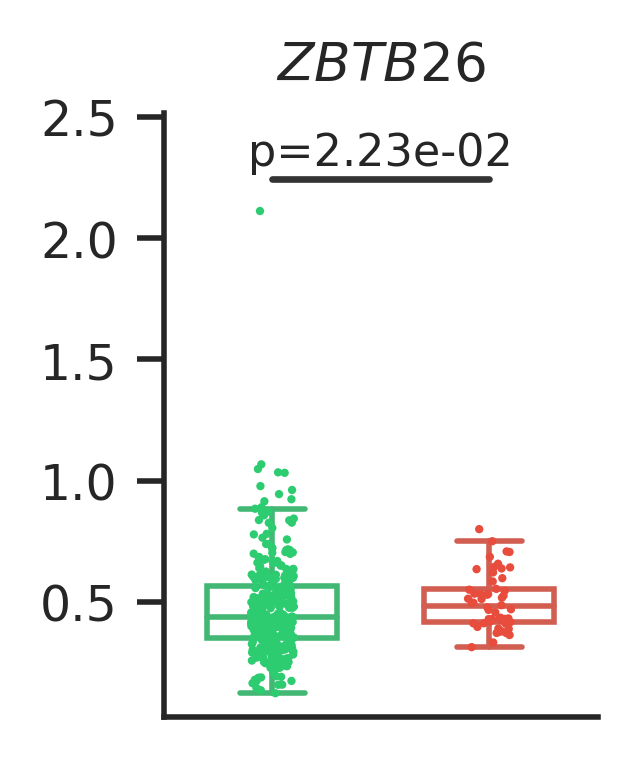

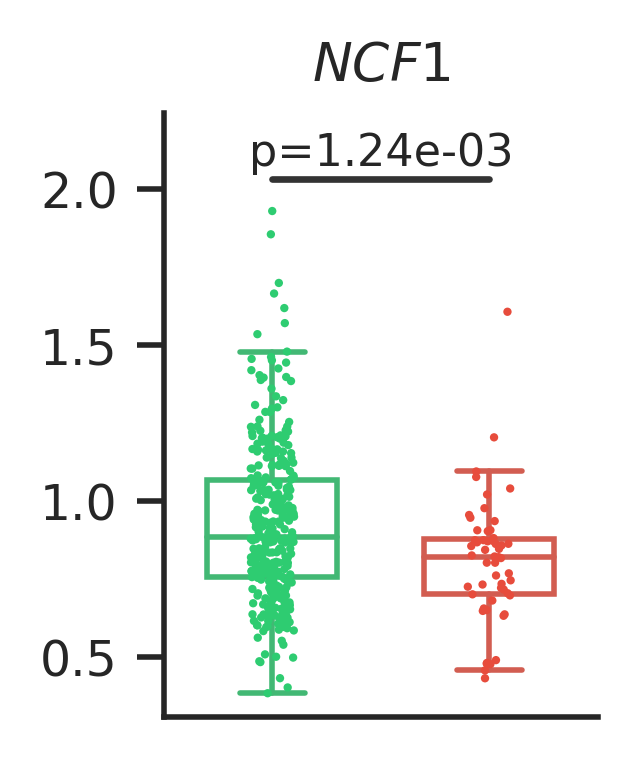

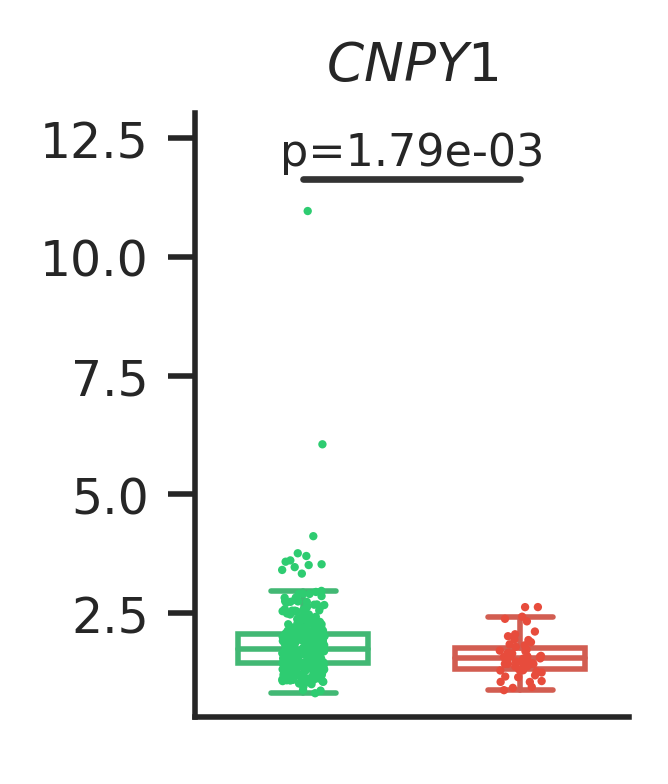

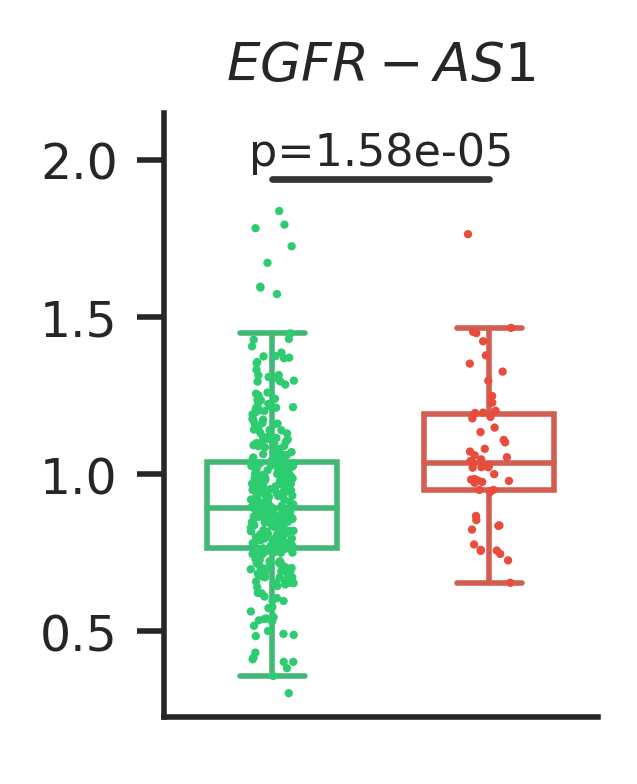

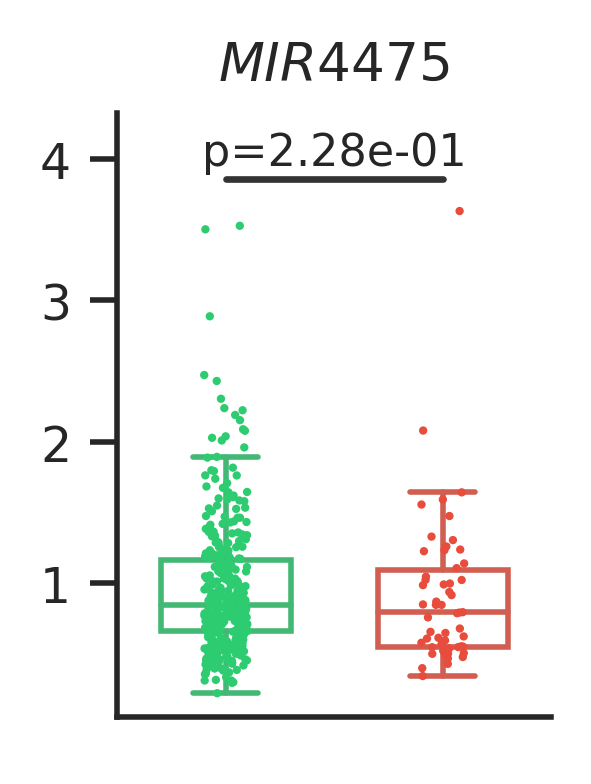

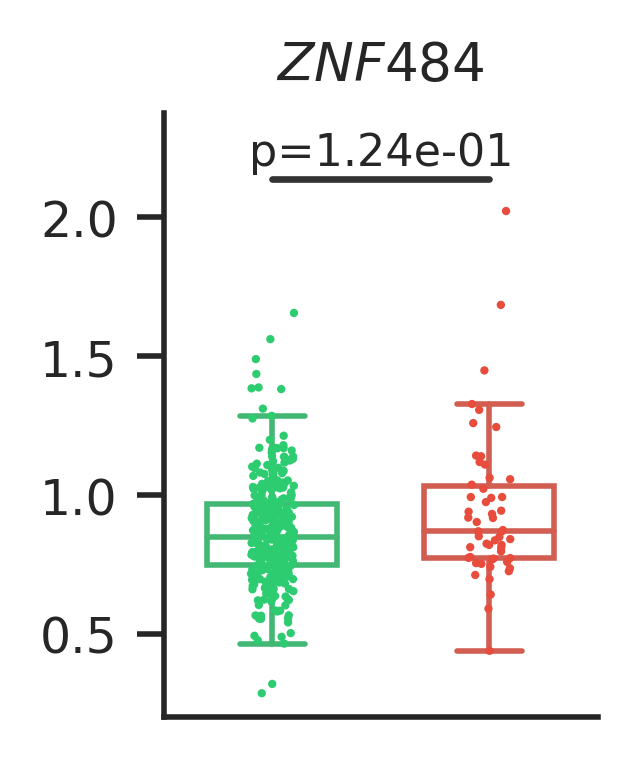

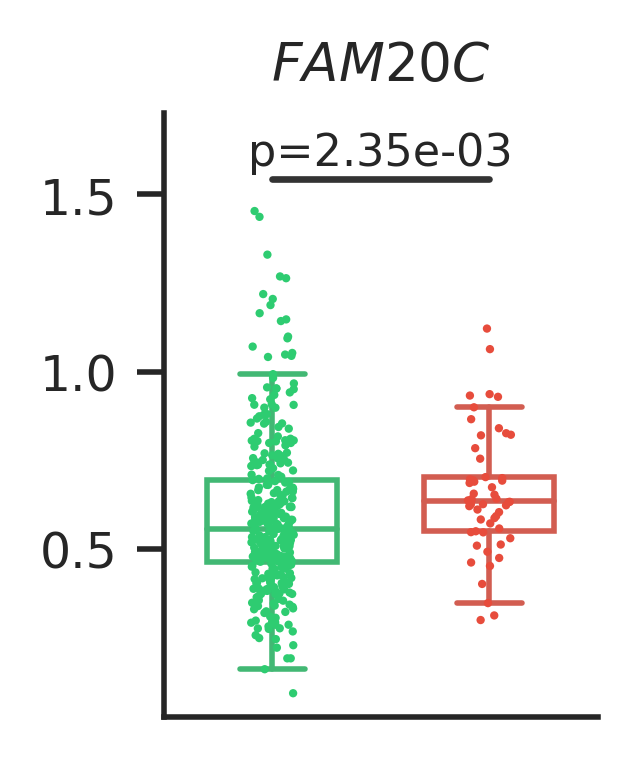

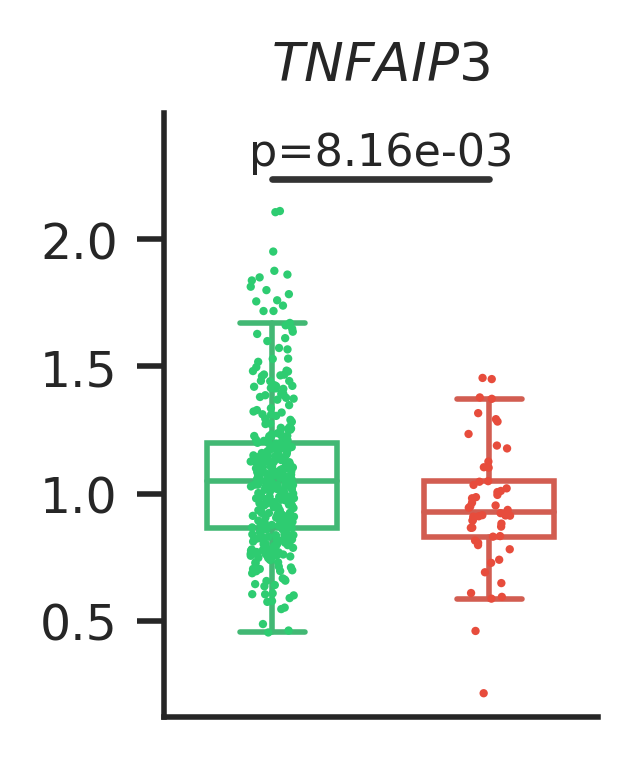

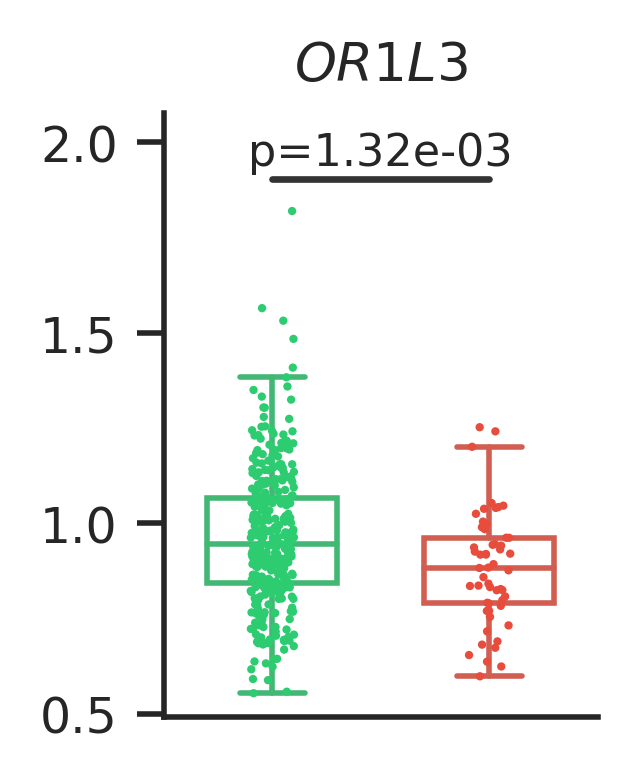

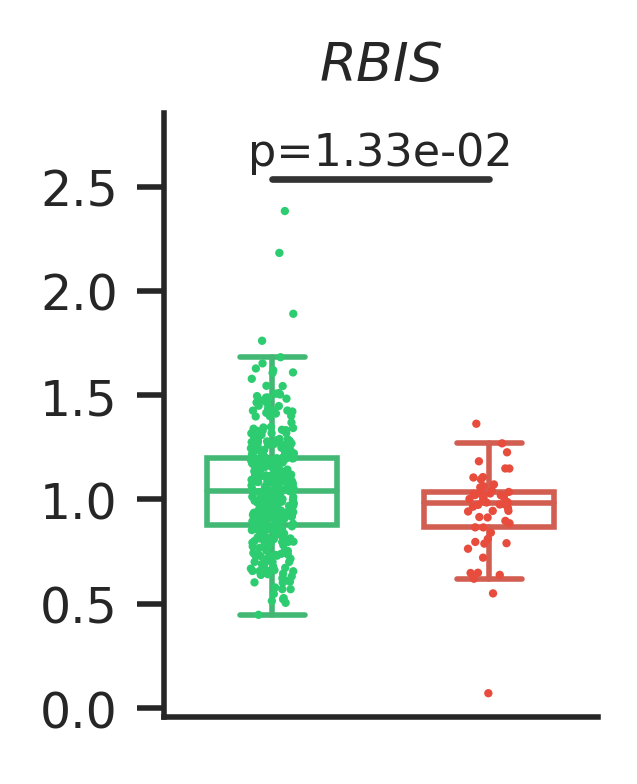

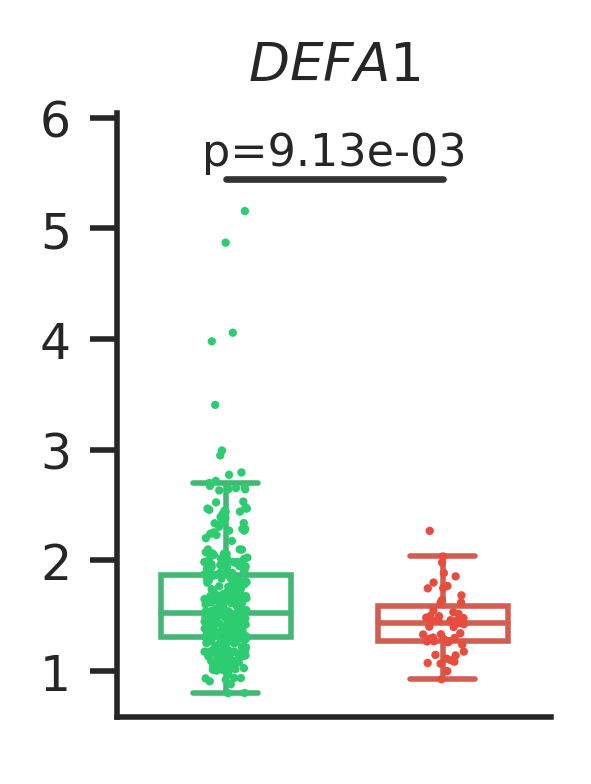

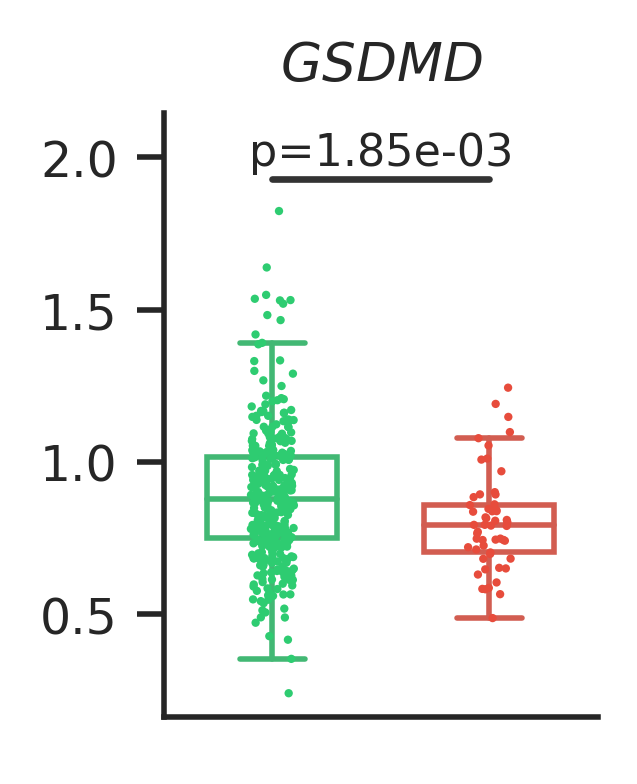

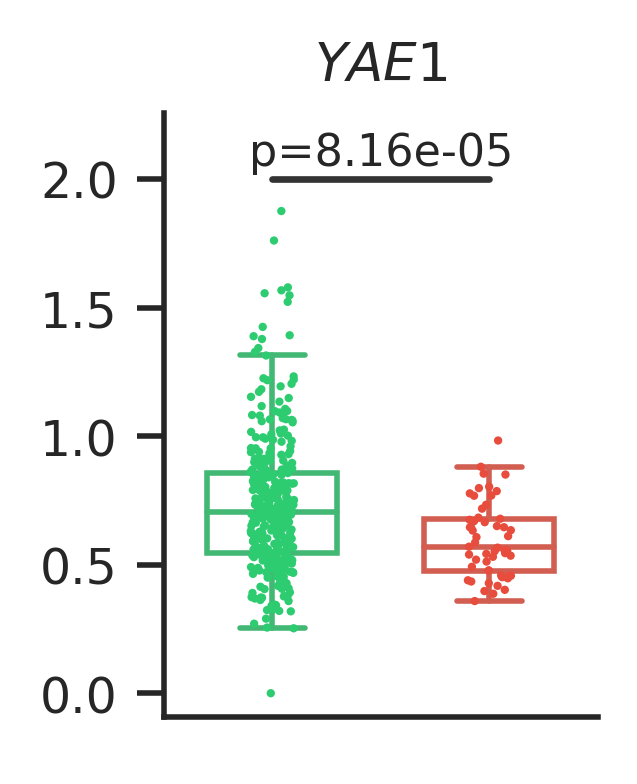

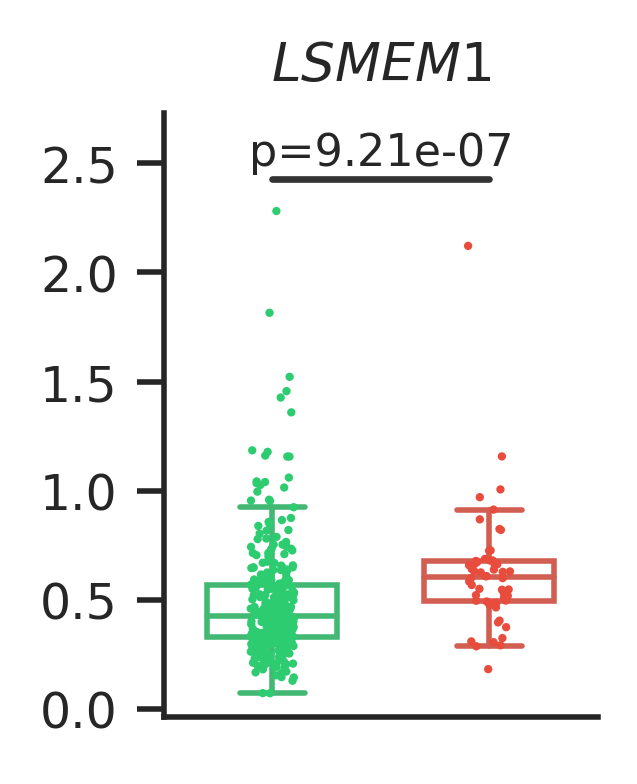

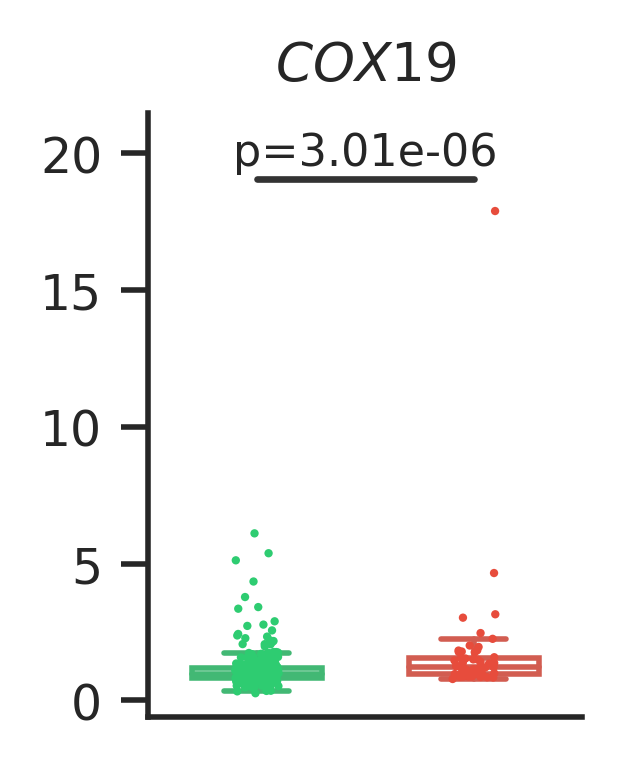

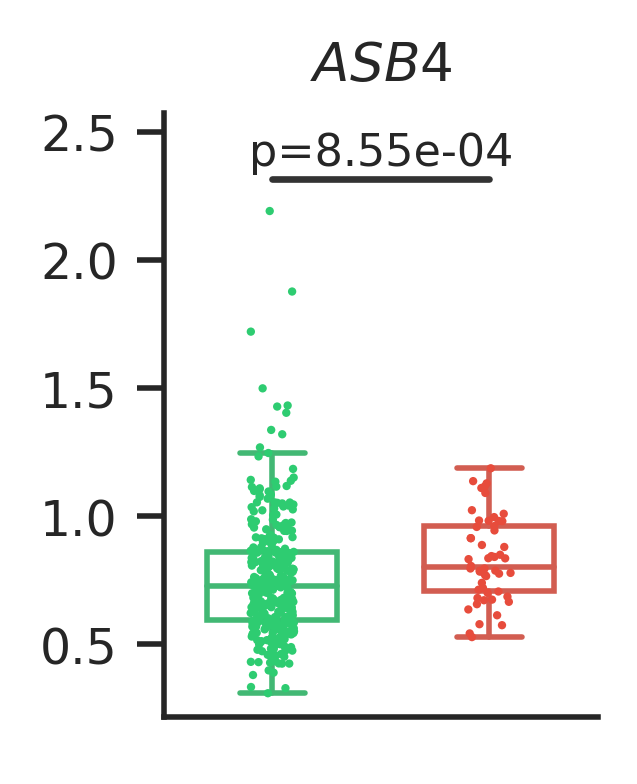

In [36]:
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu

# fig, axs = plt.subplots(1,len(i_feats_name), figsize=(6.8,2))
orders = ['Noncritical','Critical']
palette = dict(zip(orders, ['#2ecc71','#e74c3c']))

for ix in range(len(tss_names)):
    
    fig, axs = plt.subplots(1,1,figsize=(1.4,2))

    plot_param={
        'data':tss_raw_dat,
        'x':'labels',
        'y':tss_genes_map[tss_names[ix]],
        'order':orders,
        'orient':'v'
    }

    sns.stripplot(**plot_param, ax=axs,palette=palette,size=1.5)
    axa = sns.boxplot(**plot_param,ax=axs,palette=palette, showfliers=False, linewidth=1,width=0.6)

    for i,artist in enumerate(axs.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        col = artist.get_facecolor()
        artist.set_edgecolor(col)
        artist.set_facecolor('None')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i*5,i*5+5):
            line = axa.lines[j]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    noncri_values = tss_raw_dat.loc[tss_raw_dat['labels']=='Noncritical',
                                  tss_genes_map[tss_names[ix]]].values
    cri_values = tss_raw_dat.loc[tss_raw_dat['labels']=='Critical',
                               tss_genes_map[tss_names[ix]]].values

    pvalues=[mannwhitneyu(noncri_values, cri_values, alternative="two-sided").pvalue]

    formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

    anno_pairs= [(orders[0], orders[1])]
    annot = Annotator(axa, pairs=anno_pairs, **plot_param)
    annot.reset_configuration()
    annot.set_custom_annotations(formatted_pvalues)
    annot.configure(verbose=False,line_width=1.2,fontsize=8,loc='inside',line_height=0, text_offset=1)
    annot.annotate()
    # if labs_names[ix]=='LDH':
    #     axa.set_yscale('log') 
    #     axa.set_ylim((80,3000))
    # elif labs_names[ix]=='Uric_acid': 
    #     axa.set_ylim((-50,900))
    # elif labs_names[ix]=='α-HBDH': 
    #     axa.set_ylim((50,700))
    # else:
    #     axa.set_ylim((-50,650))
    
    axa.set_ylabel(None)
    axa.set_title(r'$\it{}$'.format(tss_genes_map[tss_names[ix]]))
    axa.set_xlabel(None)
    axa.set_xticks([])

    # axa.set_xticklabels(axa.get_xticklabels(),rotation=30, ha='right')
    sns.despine()
    plt.savefig("results_plt/feat_real_tss_dist_{}_{}.pdf".format(tss_names[ix], tss_genes_map[tss_names[ix]]), 
                dpi=400, bbox_inches='tight')

In [136]:
# load tss pathway data 

covid19_gene_set_fname = r'enrichr-18/COVID-19_Related_Gene_Sets_2021_table.txt'
go_bp_fname = r'enrichr-18/GO_Biological_Process_2021_table.txt'
go_cc_fname = r'enrichr-18/GO_Cellular_Component_2021_table.txt'
go_func_fname = r'enrichr-18/GO_Molecular_Function_2021_table.txt'
kegg_fname = r'enrichr-18/KEGG_2021_Human_table.txt'

covid19_gene_set_dat =pd.read_csv(os.path.join(raw_data_dir, covid19_gene_set_fname), sep='\t') # 163 items
covid19_gene_set_dat['neg_log10_p'] = -np.log10(covid19_gene_set_dat['P-value'].values)

go_bp_dat =pd.read_csv(os.path.join(raw_data_dir, go_bp_fname), sep='\t') # 182 items
go_bp_dat['neg_log10_p'] = -np.log10(go_bp_dat['P-value'].values)
go_bp_dat['Term'] = go_bp_dat['Term'].str.replace(r"\s*\(.*\)\s*","")

go_cc_dat =pd.read_csv(os.path.join(raw_data_dir, go_cc_fname), sep='\t') # 31 items
go_cc_dat['neg_log10_p'] = -np.log10(go_cc_dat['P-value'].values)
go_cc_dat['Term'] = go_cc_dat['Term'].str.replace(r"\s*\(.*\)\s*","")

go_func_dat =pd.read_csv(os.path.join(raw_data_dir, go_func_fname), sep='\t') # 38 items
go_func_dat['neg_log10_p'] = -np.log10(go_func_dat['P-value'].values)
go_func_dat['Term'] = go_func_dat['Term'].str.replace(r"\s*\(.*\)\s*","")

kegg_dat =pd.read_csv(os.path.join(raw_data_dir, kegg_fname), sep='\t') # 35 items
kegg_dat['neg_log10_p'] = -np.log10(kegg_dat['P-value'].values)


### GO and KEGG


In [155]:
kegg_dat.head()

Term Overlap   P-value  \
0      NOD-like receptor signaling pathway   4/181  0.000018   
1          Staphylococcus aureus infection    2/95  0.003251   
2  Neutrophil extracellular trap formation   2/189  0.012304   
3  Transcriptional misregulation in cancer   2/192  0.012679   
4                            Leishmaniasis    1/77  0.067105   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.000629            0                     0   31.969330   
1          0.056887            0                     0   26.732527   
2          0.110941            0                     0   13.231952   
3          0.110941            0                     0   13.021053   
4          0.206658            0                     0   15.407121   

   Combined Score                       Genes  neg_log10_p  
0      349.304587  GSDMD;TNFAIP3;DEFA1;DEFA1B     4.745206  
1      153.147502                DEFA1;DEFA1B     2.488022  
2       58.191452                  GSDMD;NCF1     1.909939  
3       56.873476                DEFA1;DEFA1B     1.896916  
4       41.622198                        NCF1     1.173243

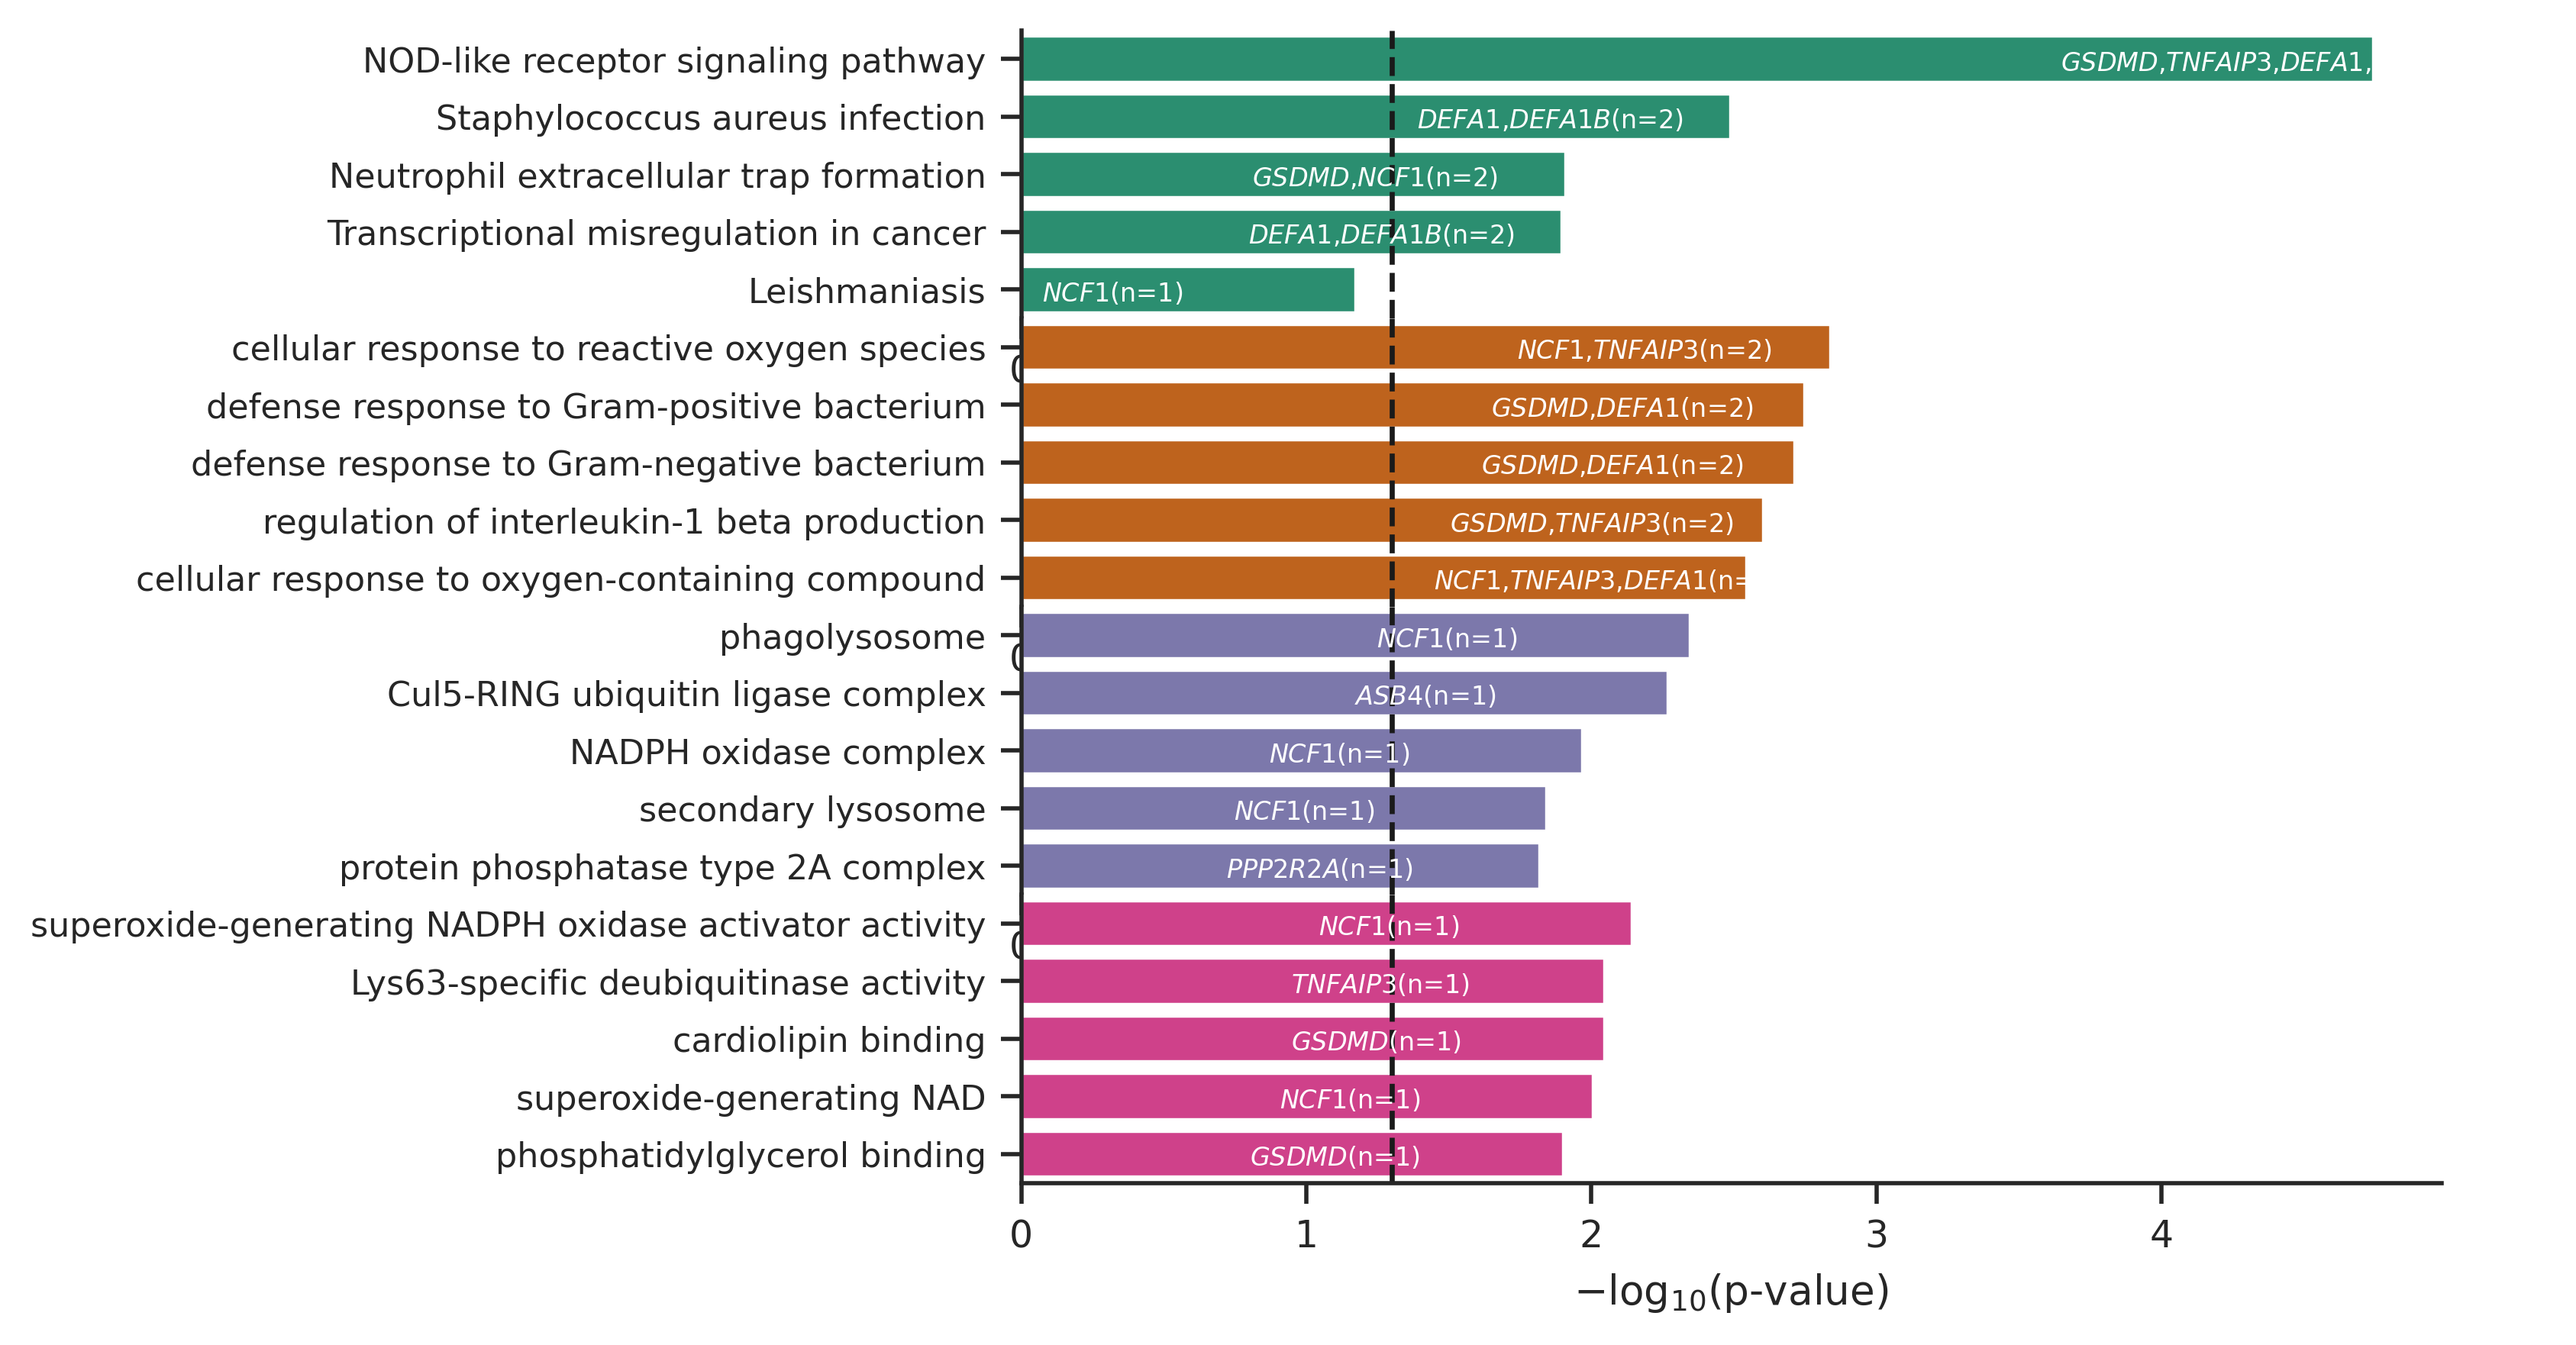

In [169]:
from matplotlib.gridspec import GridSpec

colrs = '#1b9e77,#d95f02,#7570b3,#e7298a'.split(',')
fig = plt.figure(figsize=(6,5))

gs = fig.add_gridspec(4, 1,hspace=0)
ax0 = fig.add_subplot(gs[0],)
ax1 = fig.add_subplot(gs[1],sharex=ax0)
ax2 = fig.add_subplot(gs[2],sharex=ax0)
ax3 = fig.add_subplot(gs[3],sharex=ax0)

axs = [ax0,ax1,ax2,ax3]

for k_dx, k_go_kegg_dat in enumerate([kegg_dat.head(),go_bp_dat.head(), go_cc_dat.head(), go_func_dat.head()]):
    
    axa = sns.barplot(x="neg_log10_p", y="Term", data=k_go_kegg_dat,ax=axs[k_dx],color=colrs[k_dx])
    
    for ixx,i_row in k_go_kegg_dat.iterrows():
        i_genes = [r'$\it{}$'.format(x.strip()) for x in i_row['Genes'].split(';')]
        neg_p=i_row['neg_log10_p']
        axa.text(neg_p-1.1,ixx+0.2, ','.join(i_genes)+'(n={})'.format(len(i_genes)), fontsize=6, color='w')
    
    axa.spines['top'].set_visible(False)
    axa.spines['right'].set_visible(False)
    
    if k_dx < 3:
        axs[k_dx].spines['bottom'].set_visible(False)
        # axa.set_xticks([])
    
    axa.axvline(x = -np.log10(0.05),color='k',ls='--')
    axa.set_yticklabels(axa.get_yticklabels(),fontsize=8)
    axa.set_xlabel(r'$-\log_{10}$(p-value)')
    axa.set_ylabel(None)

plt.savefig("results_plt/feat_tss_pathway.pdf", dpi=400, bbox_inches='tight')
    

#### COVID-19 Gene Set

used as supp table

In [171]:
covid19_gene_set_dat.head()

Term Overlap   P-value  \
0  SARS-CoV perturbation; 7 Up Genes from GEN3VA;...     1/7  0.006284   
1  500 genes up-regulated by SARS-CoV-2 in human ...   3/461  0.007673   
2  500 genes up-regulated by SARS-CoV-2 in human ...   3/490  0.009068   
3  SARS-CoV perturbation; 23 Up Genes from GEN3VA...    1/23  0.020507   
4  Coronavirus Perturbation; 326 Up Genes from GE...   2/266  0.023434   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.330484            0                     0  195.843137   
1          0.330484            0                     0    8.525764   
2          0.330484            0                     0    8.006160   
3          0.330484            0                     0   53.368984   
4          0.330484            0                     0    9.336174   

   Combined Score                Genes  neg_log10_p  
0      992.879272              TNFAIP3     2.201772  
1       41.520782  NCF1;LSMEM1;TNFAIP3     2.115030  
2       37.652562  NCF1;LSMEM1;TNFAIP3     2.042465  
3      207.443686              TNFAIP3     1.688090  
4       35.043826       ZNF484;TNFAIP3     1.630147